In [7]:
# import anubisPlotUtils as anPlot
import numpy as np
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
# import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import numpy as np
# from scipy.stats import normpip install pillow
sys.path.insert(1, 'Osiris Temp\processing\python')
import rawFileReader
from itertools import groupby
import math
from scipy.optimize import curve_fit

import importlib
%matplotlib inline
from collections import defaultdict

<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\3490239771.py:19: SyntaxWarning: invalid escape sequence '\p'
  sys.path.insert(1, 'Osiris Temp\processing\python')


In [86]:


class rpcHit():
    def __init__(self, channel, time, eta, event_num, rpc):
        self.rpc = rpc
        self.time = time
        self.channel = channel
        self.eta = eta
        self.event_num = event_num

    def __str__(self):
        return f"rpcHit(channel={self.channel}, time={self.time}, eta={self.eta}, event_num={self.event_num}, rpc={self.rpc})"

class rpcCoincidence():
    def __init__(self, event_num, time_bin, hits):
        self.event_num = event_num
        self.time_bin = time_bin
        self.hits = hits

    def __str__(self):
        return f"rpcCoincidence(event_num={self.event_num}, time_bin={self.time_bin}, hits={self.hits})"

class realigner():
    def __init__(self, fReader, max_process_event, adjustment = 0,
                interval = 100, monitor_factor = 3, window_size = 15,
                order = [[0,1], [1,2], [2,3], [3,4]], scDiffs = [], normDiffs = [],
                residEta = [] ,
                residPhi = [] , record_inserted_events = False,
                tof_correction = False, diffHists = [],
                successful_reconstructed_coords = [],
                failed_reconstructed_coords = [], possible_reconstructions_coords = [],
                etaHits = [[] for rpc in range(6)], phiHits = [[] for rpc in range(6)],
                dev_mode = True):
        self.events = []
        self.popt = [0, 0]
        self.temp_events = []
        self.event_chunk = []
        self.global_alignment = True
        self.globally_aligned_events = []
        self.globally_aligned_mets = [[] for _ in range(len(order))]
        self.interval = interval
        self.lastWasBad = False
        self.adjustment = adjustment
        self.order = order
        self.fReader = fReader
        self.updates = [0 for _ in range(len(order))]
        self.mets = [[] for _ in range(len(order))]
        self.offsetlist = [p for o in range(1, (4 + self.adjustment)) for p in (o, -o)]
        self.processedEvents = 0
        self.max_process_event = max_process_event
        self.insertion_list = [0 for _ in range(5)]
        self.debug_statement = dev_mode
        self.tdc3status = [True for _ in range(5)]
        self.lasttdc3Status = [True for _ in range(5)]  
        self.tdc_mets = [[] for _ in range(5)]
        self.monitor_factor = monitor_factor
        self.etaHits = etaHits
        self.phiHits = phiHits
        self.tol = [i for i in range(20)]

        self.window_size = window_size
        self.successful_reconstructions = [[0 for i in range(len(self.tol))] for rpc in range(6)]
        self.tof_correction = tof_correction
        self.possible_reconstructions = [0 for rppc in range(6)]
        self.record_inserted_events = record_inserted_events
        self.totDiffs = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                1:[[0 for etchan in range(32)] for phchan in range(64)], 
                2:[[0 for etchan in range(32)] for phchan in range(64)], 
                3:[[0 for etchan in range(32)] for phchan in range(64)],
                4:[[0 for etchan in range(32)] for phchan in range(64)],
                5:[[0 for etchan in range(32)] for phchan in range(64)]}
        self.nDiffs = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                    1:[[0 for etchan in range(32)] for phchan in range(64)], 
                    2:[[0 for etchan in range(32)] for phchan in range(64)], 
                    3:[[0 for etchan in range(32)] for phchan in range(64)],
                    4:[[0 for etchan in range(32)] for phchan in range(64)],
                    5:[[0 for etchan in range(32)] for phchan in range(64)]}
        if diffHists == []:
            self.diffHists = {0:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc0etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        1:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc1etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        2:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc2etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        3:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc3etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        4:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc4etPhiDiff")) for etchan in range(32)] for phchan in range(64)],
                        5:[[hi.Hist(hi.axis.Regular(bins=376, start=-150.4, stop=150.4, name="rpc5etPhiDiff")) for etchan in range(32)] for phchan in range(64)]}
        else:
            self.diffHists = diffHists
            
        self.residEta = residEta
        self.residPhi = residPhi
        if scDiffs == []:
            self.scDiffs = [[0 for etchan in range(32)] for phchan in range(64)]
            self.normDiffs = [[0 for etchan in range(32)] for phchan in range(64)]
        else:
            self.scDiffs = scDiffs
            self.normDiffs = normDiffs
        
        self.chi2 = []
        self.event_of_interest = []
        
        self.event_hist = [0 for _ in range(5)]
        if successful_reconstructed_coords == []:
            self.successful_reconstructed_coords = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                1:[[0 for etchan in range(32)] for phchan in range(64)], 
                2:[[0 for etchan in range(32)] for phchan in range(64)], 
                3:[[0 for etchan in range(32)] for phchan in range(64)],
                4:[[0 for etchan in range(32)] for phchan in range(64)],
                5:[[0 for etchan in range(32)] for phchan in range(64)]}
        else:
            self.successful_reconstructed_coords = successful_reconstructed_coords
        
        if failed_reconstructed_coords == []:
            self.failed_reconstructed_coords = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                1:[[0 for etchan in range(32)] for phchan in range(64)], 
                2:[[0 for etchan in range(32)] for phchan in range(64)], 
                3:[[0 for etchan in range(32)] for phchan in range(64)],
                4:[[0 for etchan in range(32)] for phchan in range(64)],
                5:[[0 for etchan in range(32)] for phchan in range(64)]}
        else:
            self.failed_reconstructed_coords = failed_reconstructed_coords
        
        if possible_reconstructions_coords == []:
            self.possible_reconstructions_coords = {0:[[0 for etchan in range(32)] for phchan in range(64)],
                1:[[0 for etchan in range(32)] for phchan in range(64)], 
                2:[[0 for etchan in range(32)] for phchan in range(64)], 
                3:[[0 for etchan in range(32)] for phchan in range(64)],
                4:[[0 for etchan in range(32)] for phchan in range(64)],
                5:[[0 for etchan in range(32)] for phchan in range(64)]}
        else:
            self.possible_reconstructions_coords = possible_reconstructions_coords
        
        self.recorded = []
        self.count = [[] for _ in range(7)]
        self.count2 = [[] for _ in range(7)]
        self.rpc_involvement = {i: [0] * 6 for i in range(7)}
        self.cluster_sizes = []
        self.successful_cluster_size = []
        
        self.eta_histogram = np.zeros(len(np.arange(-90.5, 91.5, 1)) - 1)
        self.phi_histogram = np.zeros(len(np.arange(-90.5, 91.5, 1)) - 1)
        self.solid_theta_histogram = np.zeros(len(np.arange(-180.5, 181.5, 1)) - 1)
        self.solid_phi_histogram = np.zeros(len(np.arange(-180.5, 181.5, 1)) - 1)

        
        self.frequency_dict = defaultdict(int)
        
        self.efficiency_memory = {rpc: [] for rpc in range(6)}
        self.processed_events_memory = []
        
        self.dT = []
        self.recon = []
        
        self.TDC_error_time = [[] for tdc in range(5)]
        self.TDC_alignment_time = [[] for tdc in range(5)]
        
        self.thisTDC = (-1, -1)
        self.only_header = 0
        self.only_header_values = []  
        self.processed_event_values = []
        self.tdc_event_number = [[] for tdc in range(5)]
        self.count_entries = [[] for rpc in range(6)]
            
    def get_aligned_events(self, mode = 'efficient', method = 'giveup', chi2_region = [0,100], plot_hist = False):
        while self.processedEvents<self.max_process_event:
            if not self.fReader.readBlock():
                print("Bad Block Read")
                break
            if(self.fReader.hasEvents()):
                for event in self.fReader.getEvents():
                    self.events.append(event)
                    self.temp_events.append(event)
                    self.processedEvents = self.processedEvents+1
                    if self.processedEvents < 0:
                        continue
                    if self.processedEvents%self.interval==0 and self.processedEvents>0:
                        self.event_chunk = self.temp_events[-self.interval:]
                        aligned, realigned = self.doRealign(method = method)
                        self.check_alignment_status(aligned, realigned) 
                        self.update_adjustment_window(realigned)
                        self.find_tdc_event_count()
                        
                        
                        self.only_header_values.append(self.only_header)
                        self.processed_event_values.append(self.processedEvents)

                        
                        if self.global_alignment == True:
                            print(self.processedEvents)
                            # self.readTDCTimeDiffs()
                            self.populate_hits()
                            # status, failure = self.check_eta_trigger()
                            # if status == False:
                            #     print(f'failure, processed Evenets : {self.processedEvents}, failed event : {failure[0]}')
                            #     self.recorded.append(self.etaHits)
                            cluster = self.make_cluster()
                            # for coincident_event_clustered in cluster:
                            #     self.cluster_sizes.append(self.get_cluster_sizes(coincident_event_clustered))
                            # print(len(cluster))
                            self.reconstruct_and_extrapolate(cluster, chi2_region = chi2_region)
                            # self.append_efficiency_to_memory()
                            # self.reconstruct_and_findtof(cluster)
                            # filtered_events = filter_events(cluster,1,6)
                            
                            # self.extract_angles_phi_eta_timed_DZ_modified(filtered_events)
                            
                            # self.temp_events.clear()
                            # if mode != 'Full':
                            #     self.events.clear()
                        # if self.processedEvents % (self.interval * 200) == 0:
                        #         buffer = self.fReader.reload_event_builder()
                        #         print(f'event builder reloaded, proof {buffer}')
                            self.etaHits = [[] for rpc in range(6)]
                            self.phiHits = [[] for rpc in range(6)]
                        if self.processedEvents%(self.monitor_factor * self.interval) == 0 and self.processedEvents>0:
                            self.monitor_tdc3_state(recordtimes=True)
                            self.temp_events.clear()
                            if mode != 'Full':
                                self.events.clear()
                                
                            

                
        self.outDict = {'totDiffs':self.totDiffs,
                    'nDiffs':self.nDiffs,
                    'diffHists':self.diffHists}  
        
        
    def append_efficiency_to_memory(self):
        if not hasattr(self, 'efficiency_memory'):
            self.efficiency_memory = {rpc: [] for rpc in range(6)}
            self.processed_events_memory = []

        # Record the current number of processed events
        self.processed_events_memory.append(self.processedEvents)

        for rpc in range(6):
            if self.possible_reconstructions[rpc] == 0:
                efficiency = [0 for _ in self.tol]
            else:
                efficiency = [x / self.possible_reconstructions[rpc] for x in self.successful_reconstructions[rpc]]
            
            # Append the current efficiency values to memory
            self.efficiency_memory[rpc].append(efficiency)

    def plot_efficiency_heatmap(self):

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        for rpc in range(6):
            ax = axes[rpc // 3, rpc % 3]

            # Check if there is data to plot
            if len(self.efficiency_memory[rpc]) == 0 or len(self.processed_events_memory) == 0:
                print(f"No data for RPC {rpc}. Skipping...")
                continue

            # Prepare data for the heatmap
            data = np.array(self.efficiency_memory[rpc])
            events = np.array(self.processed_events_memory)
            tol = np.array(self.tol)

            if len(events) != data.shape[0]:
                print(f"Mismatch in lengths for RPC {rpc}: events ({len(events)}), data ({data.shape[0]})")
                continue

            # Adjust bins to match pcolormesh requirements
            events_bins = np.append(events, events[-1] + (events[-1] - events[-2]))
            tol_bins = np.append(tol, tol[-1] + (tol[-1] - tol[-2]))

            if len(events_bins) != data.shape[0] + 1:
                print(f"Mismatch in events_bins length for RPC {rpc}: events_bins ({len(events_bins)}), data ({data.shape[0]})")
                continue

            if len(tol_bins) != data.shape[1] + 1:
                print(f"Mismatch in tol_bins length for RPC {rpc}: tol_bins ({len(tol_bins)}), data ({data.shape[1]})")
                continue

            # Plot the heatmap using matplotlib
            c = ax.pcolormesh(events_bins, tol_bins, data.T, cmap='viridis', norm=colors.Normalize(0, 1))
            fig.colorbar(c, ax=ax)

            ax.set_title(f'RPC {rpc}')
            ax.set_xlabel('Processed Events')
            ax.set_ylabel('Tolerance')

        plt.tight_layout()
        plt.show()


        
    def find_tdc_event_count(self):
        for tdc in range(5):
            tot_length = 0
            for event in self.event_chunk:
                length = len(event.tdcEvents[tdc].words)
                tot_length += length
            self.tdc_event_number[tdc].append(tot_length)
            
    def plot_tdc_event_count(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for tdc in range(5):
            met = self.tdc_event_number[tdc]
            binsx = [x * self.interval for x in range(len(met))]
            ax.plot(binsx, met, label=f'TDC{tdc}')

        ax.set_xlim(0, self.max_process_event)
        # ax.set_ylim(-1, 100)
        ax.legend()
        ax.set_title('TDC number of events recorded')
        ax.set_ylabel('num of events')
        ax.set_xlabel('Processed Event')
        plt.show()
          
        
        
        
        
    def update_frequency(self):
        list_tuple = tuple(self.insertion_list)
        self.frequency_dict[list_tuple] += 1
        
    def get_cluster_sizes(self, coincident_event_clustered):
        event_clusters = coincident_event_clustered[2]
        event_cluster_sizes = []
        
        for rpc in event_clusters:
            rpc_phi_clusters = rpc[0]
            rpc_eta_clusters = rpc[1]

            phi_cluster_sizes = [len(cluster) for cluster in rpc_phi_clusters]
            eta_cluster_sizes = [len(cluster) for cluster in rpc_eta_clusters]

            if not phi_cluster_sizes:
                phi_cluster_sizes.append(0)
            if not eta_cluster_sizes:
                eta_cluster_sizes.append(0)

            event_cluster_sizes.append((phi_cluster_sizes, eta_cluster_sizes))
        
        return event_cluster_sizes 
        
    def get_aligned_events_timing_compensated(self):
        while self.processedEvents<self.max_process_event:
            if not self.fReader.readBlock():
                print("Bad Block Read")
                break
            if(self.fReader.hasEvents()):
                for event in self.fReader.getEvents():
                    self.events.append(event)
                    self.temp_events.append(event)
                    self.processedEvents = self.processedEvents+1
                    if self.processedEvents%self.interval==0 and self.processedEvents!=10500:
                        self.event_chunk = self.temp_events[-self.interval:]
                        aligned, realigned = self.doRealign(method = 'giveup')
                        self.check_alignment_status(aligned, realigned)
                        self.update_adjustment_window(realigned)

                        
                        if self.global_alignment == True:
                            self.etaHits = [[] for rpc in range(6)]
                            self.phiHits = [[] for rpc in range(6)]
                            print(f'global alignmend at {self.processedEvents}')
                            self.populate_hits()
                            self.apply_systematic_correction()
                            clustered = self.make_cluster()
                            # print(len(clustered))
                            self.reconstruct_and_findtof(clustered)
            
                            self.temp_events.clear()
                            self.events.clear()
                            
                            
    # def get_aligned_events_timing_compensated(self):
    #     while self.processedEvents < self.max_process_event:
    #         start_time = time.time()
    #         if not self.fReader.readBlock():
    #             print("Bad Block Read")
    #             break
    #         read_block_time = time.time() - start_time

    #         start_time = time.time()
    #         if self.fReader.hasEvents():
    #             has_events_time = time.time() - start_time

    #             start_time = time.time()
    #             for event in self.fReader.getEvents():
    #                 self.events.append(event)
    #                 self.temp_events.append(event)
    #                 self.processedEvents += 1

    #                 if self.processedEvents % self.interval == 0 and self.processedEvents > 0:
    #                     self.event_chunk = self.temp_events[-self.interval:]

    #                     start_time = time.time()
    #                     aligned, realigned = self.doRealign(method='giveup')
    #                     realign_time = time.time() - start_time

    #                     start_time = time.time()
    #                     self.check_alignment_status(aligned, realigned)
    #                     check_alignment_status_time = time.time() - start_time

    #                     start_time = time.time()
    #                     self.update_adjustment_window(realigned)
    #                     update_adjustment_window_time = time.time() - start_time

    #                     if self.global_alignment:
    #                         self.etaHits = [[] for rpc in range(6)]
    #                         self.phiHits = [[] for rpc in range(6)]
    #                         print(f'global alignment at {self.processedEvents}')

    #                         start_time = time.time()
    #                         self.populate_hits()
    #                         populate_hits_time = time.time() - start_time

    #                         start_time = time.time()
    #                         self.apply_systematic_correction()
    #                         apply_systematic_correction_time = time.time() - start_time

    #                         start_time = time.time()
    #                         clustered = self.make_cluster()
    #                         make_cluster_time = time.time() - start_time

    #                         start_time = time.time()
    #                         self.reconstruct_and_findtof(clustered)
    #                         reconstruct_and_findtof_time = time.time() - start_time

    #                         self.temp_events.clear()
    #                         self.events.clear()

    #                         print(f'Timings:')
    #                         # print(f'Read Block Time: {read_block_time:.6f} seconds')
    #                         # print(f'Has Events Time: {has_events_time:.6f} seconds')
    #                         # print(f'Realign Time: {realign_time:.6f} seconds')
    #                         # print(f'Check Alignment Status Time: {check_alignment_status_time:.6f} seconds')
    #                         # print(f'Update Adjustment Window Time: {update_adjustment_window_time:.6f} seconds')
    #                         # print(f'Populate Hits Time: {populate_hits_time:.6f} seconds')
    #                         # print(f'Apply Systematic Correction Time: {apply_systematic_correction_time:.6f} seconds')
    #                         print(f'Make Cluster Time: {make_cluster_time:.6f} seconds')
    #                         print(f'Reconstruct and Find TOF Time: {reconstruct_and_findtof_time:.6f} seconds')
                            
    def get_event(self, event_num):
        while self.processedEvents<self.max_process_event:
            if not self.fReader.readBlock():
                print("Bad Block Read")
                break
            if(self.fReader.hasEvents()):
                for event in self.fReader.getEvents():
                    self.events.append(event)
                    self.temp_events.append(event)
                    self.processedEvents = self.processedEvents+1
                    if self.processedEvents%self.interval==0 and self.processedEvents>0:
                        self.event_chunk = self.temp_events[-self.interval:]
                        aligned, realigned = self.doRealign(method = 'giveup')
                        self.check_alignment_status(aligned, realigned)
                        self.update_adjustment_window(realigned)
                        self.etaHits = [[] for rpc in range(6)]
                        self.phiHits = [[] for rpc in range(6)]
                        for idx, event in enumerate(self.event_chunk):
                            if self.processedEvents + idx == event_num:
                                self.event_chunk = [event]
                        self.temp_events.clear()
                        self.events.clear()
    
                                
                                

        # self.outDict = {'totDiffs':self.totDiffs,
        #             'nDiffs':self.nDiffs,
        #             'diffHists':self.diffHists} 
        
        
        
    def apply_systematic_correction(self):
        for rpc in range(6):
            for i, etahit in enumerate(self.etaHits[rpc]):
                self.etaHits[rpc][i].time += self.residEta[rpc][etahit.channel]
            for j , phihit in enumerate(self.phiHits[rpc]):
                self.phiHits[rpc][j].time += self.residPhi[rpc][phihit.channel]
                                
    def readTDCTimeDiffs(self):
        for event in self.event_chunk:
            rpcHits = tdcEventToRPCData(event,activeTDCs=[0,1,2,3,4])
            for rpc in [0,1,2,3,4,5]:
                minEtaHit = rpcHit(-1,1000,True, self.processedEvents, rpc)
                minPhiHit = rpcHit(-1,1000,False, self.processedEvents, rpc)
                for hit in rpcHits[rpc]:
                    if hit.time>150 and hit.time<300:
                        if hit.eta and hit.time<minEtaHit.time:
                            minEtaHit = hit
                        elif hit.time<minPhiHit.time and not hit.eta:
                            minPhiHit = hit
                if minEtaHit.channel>-0.5 and minPhiHit.channel>-0.5:
                    self.totDiffs[rpc][minPhiHit.channel][minEtaHit.channel] = self.totDiffs[rpc][minPhiHit.channel][minEtaHit.channel]+minEtaHit.time-minPhiHit.time
                    self.nDiffs[rpc][minPhiHit.channel][minEtaHit.channel] = self.nDiffs[rpc][minPhiHit.channel][minEtaHit.channel]+1
                    self.diffHists[rpc][minPhiHit.channel][minEtaHit.channel].fill(minEtaHit.time-minPhiHit.time)
    
    def make_cluster(self):
        coincident_hits = FindCoincidentHits(self.etaHits, self.phiHits, self.window_size, tof_correction=self.tof_correction)
        clustered = cluster(coincident_hits)
        return clustered
    
    
    
    # def make_cluster(self):
    #     # Timing the FindCoincidentHits function
    #     start_time = time.time()
    #     coincident_hits = FindCoincidentHits(self.etaHits, self.phiHits, self.window_size, tof_correction=self.tof_correction)
    #     elapsed_time_find_hits = time.time() - start_time
        
    #     # Timing the cluster function
    #     start_time = time.time()
    #     clustered = cluster(coincident_hits)
    #     elapsed_time_cluster = time.time() - start_time
        
    #     # Print or store the elapsed times
    #     print(f"Time taken by FindCoincidentHits: {elapsed_time_find_hits:.6f} seconds")
    #     print(f"Time taken by cluster: {elapsed_time_cluster:.6f} seconds")
        
    #     return clustered
    
    def plot_chess_board_reconstruction(self):
        success_events = [[0 for etchan in range(32)] for phchan in range(64)]
        fail_events = [[0 for etchan in range(32)] for phchan in range(64)]
        rpcNames = {0:"Triplet Low",1: "Triplet Mid", 2:"Triplet Top", 3:"Singlet",4:"Doublet Low",5:"Doublet Top"}
        for rpc in range(6):
            for ph in range(64):
                for et in range(32):
                    if self.successful_reconstructed_coords[rpc][ph][et] >0:
                        total_successful = self.successful_reconstructed_coords[rpc][ph][et]
                        total_events = self.possible_reconstructions_coords[rpc][ph][et]
                        if total_events > 0:
                            success_events[ph][et] = total_successful / total_events
                        else:
                            success_events[ph][et] = 0  # No events, efficiency is 0
                    # if sum(self.failed_reconstructed_coords[rpc][ph][et].counts())>0:
                    #     fail_events[ph][et]=sum([thisVal*self.failed_reconstructed_coords[rpc][ph][et].axes.centers[0][idx] for idx, thisVal in enumerate(self.failed_reconstructed_coords[rpc][ph][et])])

            fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
            etachannels = [x-0.5 for x in range(33)]
            phichannels = [x-0.5 for x in range(65)]
            etaHist = (success_events,np.array(phichannels),np.array(etachannels))
            zrange = [0,max(max(row) for row in success_events)]
            thisHist = hep.hist2dplot(etaHist,norm=colors.Normalize(zrange[0],zrange[1]))
            thisHist.cbar.set_label('successful reconstructions / Possbile reconstruction', rotation=270, y=0.3,labelpad=23)
            plt.ylim(31.5,-0.5)
            plt.ylabel("Eta Channel")
            plt.xlabel("Phi Channel")
            ax.set_title(rpcNames[rpc])
            x_points = [-0.5, 64.5]
            y_points = [7.5, 15.5, 23.5]
            for y_point in y_points:
                plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
            y_points = [-0.5, 31.5]
            x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
            for x_point in x_points:
                plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
            plt.show()
            
            # fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
            # etachannels = [x-0.5 for x in range(33)]
            # phichannels = [x-0.5 for x in range(65)]
            # etaHist = (fail_events,np.array(phichannels),np.array(etachannels))
            # zrange = [0,max(max(row) for row in fail_events)]
            # thisHist = hep.hist2dplot(etaHist,norm=colors.Normalize(zrange[0],zrange[1]))
            # thisHist.cbar.set_label('failed reconstructions', rotation=270, y=0.3,labelpad=23)
            # plt.ylim(31.5,-0.5)
            # plt.ylabel("Eta Channel")
            # plt.xlabel("Phi Channel")
            # ax.set_title(rpcNames[rpc])
            # x_points = [-0.5, 64.5]
            # y_points = [7.5, 15.5, 23.5]
            # for y_point in y_points:
            #     plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
            # y_points = [-0.5, 31.5]
            # x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
            # for x_point in x_points:
            #     plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
            # plt.show()
    def plot_count_entries(self):
            for rpc in range(6):
                plt.figure(figsize=(10, 6))
                plt.plot(self.count_entries[rpc], marker='o', linestyle='-', label=f'RPC {rpc}')
                plt.title(f'Numver of clusters for RPC {rpc}')
                plt.xlabel('event number')
                plt.ylabel('Count of clusters')
                plt.legend()
                plt.grid(True)
                plt.show()
            
    def reconstruct_and_extrapolate(self, dataset, chi2_region = [0, 100], plot_hist = False, angle_extraction = True):
        # Ensure RPC is a list, even if it's a single integer
        if 1 == 1:
            for rpc in range(6):
                for i, data in enumerate(dataset):
                        E_recon = reconstruct_timed_Chi2_ByRPC(data, 3, rpc)
                        if E_recon:
                            print('yes')
                            if len(E_recon[2]) >= 5:
                                if E_recon[4] > chi2_region[0] and E_recon[4] < chi2_region[1]:
                                    # self.chi2.append(E_recon[4])
                                    # self.event_of_interest.append(E_recon)
                                    # Adding this check to see if other 5 RPCs are in reconstructed event.
                                    # This is necessary to ensure the reconstructed path is accurate.

                                    muon_coords = does_muon_hit_RPC(E_recon[0], E_recon[1], rpc)

                                    if muon_coords:
                                        self.possible_reconstructions[rpc] += 1
                                        self.possible_reconstructions_coords[rpc][int(muon_coords[0] / 2.7625)][int(muon_coords[1] / 2.9844)] += 1
                                        for idx, t in enumerate(self.tol):
                                            check = does_RPC_detect_muon(muon_coords, E_recon[7], t)
                                            if check:
                                                self.successful_reconstructions[rpc][idx] += 1
                                                # if plot_hist:
                                                    # self.successful_reconstructed_coords[rpc][int(E_recon[7][0][0][0] / 2.7625)][int(E_recon[7][1][0][0] / 2.9844)].fill(1)
                                                self.successful_reconstructed_coords[rpc][int(muon_coords[0] / 2.7625)][int(muon_coords[1] / 2.9844)] += 1
                                                self.successful_cluster_size.append(self.get_cluster_sizes(data))
    
    def reconstruct_and_findtof(self, dataset, chi2_region = [0, 100]):
        for i, data in enumerate(dataset):
                E_recon = reconstruct_timed_Chi2_ByRPC(data, 3, -1)
                if E_recon:
                    if len(E_recon[2]) >= 6:
                        self.dT.append(E_recon[5])
                        self.recon.append(E_recon)
                            
                                            
                                                
                                                
    def extract_angles_phi_eta_timed_DZ_modified(self, filtered_events, max_length=None, exact_length=False):
        angles_eta = []
        angles_phi = []
        delta_times = []
        dZ = []
        chi2_values = []
        solid_angle = []
        
        bin_size = 1
        eta_phi_bin_edges = np.arange(-90.5, 91.5, bin_size)
        solid_phi_bin_edges = np.arange(-180.5, 181.5, bin_size)

        for i, filtered_event in enumerate(filtered_events):
            result = reconstruct_timed_Chi2_modified(filtered_event, 3, max_length=max_length, exact_length=exact_length)

            if result is not None:
                delta_times.append(result[5])
                chi2_values.append(result[4])
                dZ.append(result[6])

                v_parr_eta = np.array([0, result[1][1], result[1][2]])
                theta_eta = np.arccos(np.dot(v_parr_eta, [0, 0, 1]) / np.linalg.norm(v_parr_eta))

                if theta_eta > np.pi / 2:
                    theta_eta = np.pi - theta_eta
                if v_parr_eta[1] > 0:
                    theta_eta *= -1

                angles_eta.append(theta_eta)

                v_parr_phi = np.array([result[1][0], 0, result[1][2]])
                theta_phi = np.arccos(np.dot(v_parr_phi, [0, 0, 1]) / np.linalg.norm(v_parr_phi))

                if theta_phi > np.pi / 2:
                    theta_phi = np.pi - theta_phi
                if v_parr_phi[0] < 0:
                    theta_phi *= -1

                angles_phi.append(theta_phi)

                magnitude = np.linalg.norm(result[1])
                theta = np.arccos(result[1][2] / -magnitude)  # Polar angle
                phi = np.arctan2(result[1][1], result[1][0])  # Azimuthal angle

                # Normalize phi to the range [-π, π]
                if phi > np.pi:
                    phi -= 2 * np.pi
                elif phi < -np.pi:
                    phi += 2 * np.pi

                # Convert angles to degrees
                theta_deg = np.degrees(theta)
                
                phi_deg = np.degrees(phi)
                if -90 == phi_deg:
                    self.recorded.append(result)

                # Append the solid angle (theta, phi) to self.angles_solid
                solid_angle.append((theta_deg, phi_deg))

        angles_eta_degrees = [x * (180 / np.pi) for x in angles_eta]
        angles_phi_degrees = [x * (180 / np.pi) for x in angles_phi]
        angles_solid_theta_degrees = [x for x, y in solid_angle]
        angles_solid_phi_degrees = [y for x, y in solid_angle]

        self.eta_histogram += np.histogram(angles_eta_degrees, bins=eta_phi_bin_edges)[0]
        self.phi_histogram += np.histogram(angles_phi_degrees, bins=eta_phi_bin_edges)[0]
        self.solid_theta_histogram += np.histogram(angles_solid_theta_degrees, bins=solid_phi_bin_edges)[0]
        self.solid_phi_histogram += np.histogram(angles_solid_phi_degrees, bins=solid_phi_bin_edges)[0]


                                
    def plot_angle_distribution_absolute(self):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))
        bin_edges = np.arange(-90.5, 91.5, 1)
        phi_edges = np.arange(-180.5, 181.5, 1)
        ax1.bar(bin_edges[:-1], self.eta_histogram, width=1, edgecolor='black', align='edge')
        ax1.set_title('eta Angles Histogram')
        ax1.set_xlabel('eta Angle (degrees)')
        ax1.set_ylabel('Counts')

        ax2.bar(bin_edges[:-1], self.phi_histogram, width=1, edgecolor='black', align='edge')
        ax2.set_title('phi Angles Histogram')
        ax2.set_xlabel('phi Angle (degrees)')
        ax2.set_ylabel('Counts')
        
        ax3.bar(phi_edges[:-1], self.solid_theta_histogram, width=1, edgecolor='black', align='edge')
        ax3.set_title('solid theta Angles Histogram')
        ax3.set_xlabel('solid theta Angle (degrees)')
        ax3.set_ylabel('Counts')
        
        ax4.bar(phi_edges[:-1], self.solid_phi_histogram, width=1, edgecolor='black', align='edge')
        ax4.set_title('solid phi Angles Histogram')
        ax4.set_xlabel('solid phi Angle (degrees)')
        ax4.set_ylabel('Counts')


        plt.tight_layout()
        plt.show()
                                                    
    def check_eta_trigger(self):
        event_counts = {}

        for rpc_index, rpc_hits in enumerate(self.etaHits):
            unique_events_in_rpc = set()

            for hit in rpc_hits:
                unique_events_in_rpc.add(hit.event_num)

            for event_num in unique_events_in_rpc:
                if event_num not in event_counts:
                    event_counts[event_num] = 0
                event_counts[event_num] += 1

        for event_num, count in event_counts.items():
            if self.processedEvents<15000:
                if count >= 6:
                    self.count[6].append(event_num)
                else:
                    self.count[count].append(event_num)
            elif 25000<self.processedEvents<40000:
                if count >= 6:
                    self.count2[6].append(event_num)
                else:
                    self.count2[count].append(event_num)

            for rpc_index, rpc_hits in enumerate(self.etaHits):
                if any(hit.event_num == event_num for hit in rpc_hits):
                    if count >= 6:
                        self.rpc_involvement[6][rpc_index] += 1
                    else:
                        self.rpc_involvement[count][rpc_index] += 1
        # print(event_counts)
        self.processedEvents

        # Check for failed events (count < 4)
        failed_events = [(event_num, count) for event_num, count in event_counts.items() if count < 4]

        if failed_events:
            return False, failed_events
        else:
            return True, None

    def plot_rpc_involvement_histogram(self):
        plt.figure(figsize=(10, 6))
        bar_width = 0.1 
        index = range(6)

        for i, count in enumerate(range(7)):
            total = sum(self.rpc_involvement[count])

            if total == 0:
                normalized = [0] * len(self.rpc_involvement[count])
            else:
                normalized = [rpc_count / total for rpc_count in self.rpc_involvement[count]]

            plt.bar([x + i * bar_width for x in index], normalized, bar_width, label=f'Count {count}')

        plt.xlabel('RPC Number')
        plt.ylabel('Proportion of Events')
        plt.title('Normalized RPC Involvement in Event Counts')
        plt.xticks([x + bar_width * 3 for x in index], index) 
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Display the plot
        plt.show()
    
       
                                                
        
    def plot_efficiency(self, text = 'Efficiency vs Tolerance error state realign region qual == 0'):
        plt.figure(figsize=(10, 6))
        for RPC in range(6):
            if self.possible_reconstructions[RPC] == 0:
                efficiency = [0 for x in self.successful_reconstructions[RPC]]
            else:
                efficiency = [x / self.possible_reconstructions[RPC] for x in self.successful_reconstructions[RPC]]
            plt.plot(self.tol, efficiency, label=f'RPC {RPC}')

        plt.xlabel('Tolerance')
        plt.ylabel('Efficiency')
        plt.title(text)
        plt.legend()
        plt.grid(True)
        plt.show()
        print(self.possible_reconstructions)
           
    def populate_hits(self):
        skip_event = False
        for idx, event in enumerate(self.event_chunk):
            for tdc in range(5):
                if event.tdcEvents[tdc].qual != 0:
                    skip_event = True
                    break 

            if skip_event:
                continue 
            for tdc in range(5):
                for word in event.tdcEvents[tdc].words:
                    rpc, thisHit = tdcChanToRPCHit(word,tdc, self.processedEvents + idx)
                    if thisHit.channel == [0]:
                        continue
                    if thisHit.eta:
                        self.etaHits[rpc].append(thisHit)

                    else:
                        self.phiHits[rpc].append(thisHit)
    
    def plot_event_count_histogram(self):
        event_counts = [0] * 7

        for count in range(7):
            event_counts[count] = len(self.count[count])

        plt.figure(figsize=(10, 6))
        plt.bar(range(7), event_counts, color='skyblue', edgecolor='black')
        plt.xlabel('trigger Number')
        plt.ylabel('Number of Events')
        plt.title('Histogram of Event Counts')
        plt.xticks(range(7)) 
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        label_text = f'Number of events probed: {self.max_process_event}'
        plt.text(0.95, 0.95, label_text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

        plt.show()
                      
    def plotTDCTimeDiffs(self, showplot = True, max_itr = 1):
        badPhi = {0:[],1:[],2:[31], 3:[0],4:[19], 5:[31]}
        badEta = {0:[29,30,31],1:[16, 20],2:[],3:[20, 31],4:[], 5:[]}
        self.residEtaLatest = []
        self.residPhiLatest = []
        rpcNames = {0:"Triplet Low",1: "Triplet Mid", 2:"Triplet Top", 3:"Singlet",4:"Doublet Low",5:"Doublet Top"}
        evtCount = 0
        for rpc in [0,1,2,3,4,5]:
            slope = 0.15204446322001586
            offSet = 16.101626655986728
            for ph in range(64):
                for et in range(32):
                    if sum(self.outDict['diffHists'][rpc][ph][et].counts())>0:
                        self.scDiffs[ph][et]=sum([thisVal*self.outDict['diffHists'][rpc][ph][et].axes.centers[0][idx] for idx, thisVal in enumerate(self.outDict['diffHists'][rpc][ph][et])])/sum(self.outDict['diffHists'][rpc][ph][et].counts())
                        self.normDiffs[ph][et]=self.scDiffs[ph][et]+slope*(ph-et)-offSet
            
            if showplot:
                fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
                etachannels = [x-0.5 for x in range(33)]
                phichannels = [x-0.5 for x in range(65)]
                etaHist = (self.scDiffs,np.array(phichannels),np.array(etachannels))
                zrange = [-5,30]
                thisHist = hep.hist2dplot(etaHist,norm=colors.Normalize(zrange[0],zrange[1]))
                thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
                plt.ylim(31.5,-0.5)
                plt.ylabel("Eta Channel")
                plt.xlabel("Phi Channel")
                ax.set_title(rpcNames[rpc])
                x_points = [-0.5, 64.5]
                y_points = [7.5, 15.5, 23.5]
                for y_point in y_points:
                    plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
                y_points = [-0.5, 31.5]
                x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
                for x_point in x_points:
                    plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
                plt.show()
                fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
                normHist = (self.normDiffs,np.array(phichannels),np.array(etachannels))
                zrange = [-4,4]
                thisHist = hep.hist2dplot(normHist,norm=colors.Normalize(zrange[0],zrange[1]))
                thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
                plt.ylim(31.5,-0.5)
                plt.ylabel("Eta Channel")
                plt.xlabel("Phi Channel")

                x_points = [-0.5, 64.5]
                y_points = [7.5, 15.5, 23.5]
                for y_point in y_points:
                    plt.plot(x_points, [y_point,y_point], 'k', linestyle='dotted')
                y_points = [-0.5, 31.5]
                x_points = [7.5,15.5, 23.5, 31.5, 39.5, 47.5, 55.5]
                for x_point in x_points:
                    plt.plot([x_point,x_point], y_points, 'k', linestyle='dashed')
                ax.set_title(rpcNames[rpc]+", Propagation Time Corrected")
                plt.show()
            phTimes = [0 for chan in range(64)]
            etTimes = [0 for chan in range(32)]
            testSpeed = 0.173
            offSet = 13.46     
            itr = 0
            for phchan in range(64):
                for etchan in range(32):
                    if etchan not in badEta[rpc]:
                        phTimes[phchan] += self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet)
                phTimes[phchan] /= (32. - len(badEta[rpc]))

            itr += 1

            for phchan in range(64):
                for etchan in range(32):
                    if phchan not in badPhi[rpc]:
                        etTimes[etchan] += (self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet) - phTimes[phchan]) / (64. - len(badPhi[rpc]))

            itr += 1
            
            while itr <= max_itr:
                for phchan in range(64):
                    for etchan in range(32):
                        if etchan not in badEta[rpc]:
                            phTimes[phchan] += (self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet) + etTimes[etchan]) / (32. - len(badEta[rpc]))
                for phchan in range(64):
                    for etchan in range(32):
                        if phchan not in badPhi[rpc]:
                            etTimes[etchan] += (self.scDiffs[phchan][etchan] + (-etchan * testSpeed + phchan * testSpeed - offSet) - phTimes[phchan]) / (64. - len(badPhi[rpc]))
                
                itr += 1
            self.residEtaLatest.append([time for time in etTimes])
            self.residPhiLatest.append([time for time in phTimes]) 

    def plotchi2(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.hist(self.chi2, bins=100, label='Chi2 Values')
        ax.legend()
        ax.set_title('Chi2 distribution')
        ax.set_ylabel('Number of events')
        ax.set_xlabel('Chi2 values')
        plt.show()
    
    def plottdcresidual(self):
        rpcNames = {0:"Triplet Low",1: "Triplet Mid", 2:"Triplet Top", 3:"Singlet",4:"Doublet Low",5:"Doublet Top"}
        fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
        phichannels = [x-0.5 for x in range(65)]

        for idx, rpc in enumerate([0,1,2,3,4,5]):
            plotPhiResids = self.residPhiLatest[idx].copy()
            plotPhiResids.append(plotPhiResids[-1])
            plt.step(phichannels,plotPhiResids,linewidth=3,label=rpcNames[rpc],where='post')
        yrange = ax.get_ylim()
        #ax.text(40, 0.8*yrange[1], "Slope: "+str(round(popt[0],3))+" ns/channel, Offset: "+str(round(popt[1],2))+" ns", fontsize=14,
        #               verticalalignment='top')
        ax.set_xlabel('$\phi$ Channel')
        ax.set_ylabel('Time Residual (ns)')
        # ax.set_ylim([-6,6])
        ax.set_xlim([-0.5,63.5])
        plt.legend()
        plt.show()
        fig, ax = plt.subplots(1, figsize=(16, 8), dpi=100)
        etchannels = [x-0.5 for x in range(33)]
        for idx, rpc in enumerate([0,1,2,3,4,5]):
            plotEtaResids = self.residEtaLatest[idx].copy()
            plotEtaResids.append(plotEtaResids[-1])
            plt.step(etchannels,plotEtaResids,linewidth=3,label=rpcNames[rpc],where='post')
        yrange = ax.get_ylim()
        #ax.text(40, 0.8*yrange[1], "Slope: "+str(round(popt[0],3))+" ns/channel, Offset: "+str(round(popt[1],2))+" ns", fontsize=14,
        #               verticalalignment='top')
        ax.set_xlabel('$\eta$ Channel')
        ax.set_ylabel('Time Residual (ns)')
        # ax.set_ylim([-6,6])
        ax.set_xlim([-0.5,31.5])
        plt.legend()
        plt.show()               
                                            
    def plot_global_alignment_metric(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for idx, item in enumerate(self.order):
            met = self.globally_aligned_mets[idx]
            i, j = item
            binsx = [x*self.interval for x in range(len(met))]
            ax.plot(binsx,met,label=f'TDC{i} and TDC{j}, offset 0')

        ax.set_xlim(0,self.max_process_event)
        # ax.set_ylim(0,40)
        ax.legend()
        ax.set_title('Alignment graph')
        ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
        ax.set_xlabel('processed Event')
        plt.show()                      
                                                     
    def monitor_tdc3_state(self, recordtimes=False):
        for tdc in range(5):
            poor_time_count = 0
            good_time_count = 0
            for event in self.temp_events[-(self.monitor_factor * self.interval):]:
                words = event.tdcEvents[tdc].words
                times_words = [(word & 0xfffff, word) for word in words if (word >> 24) & 0x7f not in []]
                if times_words:
                    min_time, min_word = min(times_words, key=lambda x: x[0])
                    if recordtimes:
                        self.TDC_error_time[tdc].append([(min_time, min_word), self.processedEvents])
                    if min_time > 300:
                        poor_time_count += 1
                    elif 200 < min_time <= 300:
                        good_time_count += 1

            if good_time_count == 0:
                self.tdc_mets[tdc].append(1)
                if self.lasttdc3Status[tdc]:
                    print(f'tdc{tdc} error state through no good time')
                    self.lasttdc3Status[tdc] = False
            else:
                ratio = poor_time_count / good_time_count
                self.tdc_mets[tdc].append(ratio)

                if ratio > 0.5:
                    self.tdc3status[tdc] = False
                    if self.lasttdc3Status[tdc]:
                        print(f'tdc{tdc} enters error state through metric')
                        self.lasttdc3Status[tdc] = False
                else:
                    self.tdc3status[tdc] = True
                    if not self.lasttdc3Status[tdc]:
                        print(f'tdc{tdc} enters nominal state through metric')
                        self.lasttdc3Status[tdc] = True
                        buffer = self.fReader.reload_event_builder()
                        print(f'event builder reloaded, proof {buffer}')
        
    def plot_tdc_error_times(self):
        plt.figure(figsize=(12, 8))
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        bins = list(range(0, 1251, 50)) + [float('inf')]  
        text_offset = 0.1  

        for tdc in range(5):
            min_times = [entry[0] for entry in self.TDC_error_time[tdc]]
            counts, bin_edges = np.histogram(min_times, bins=bins)
            bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
            bin_centers[-1] = 1251
            plt.plot(bin_centers, counts, label=f'TDC {tdc}', linestyle='-', marker='o', color=colors[tdc])

            overflow_count = counts[-1]
            if overflow_count > 0:
                plt.text(1200, 100 * text_offset, f'overflow count == {overflow_count}', fontsize=12, 
                        ha='center', va='bottom', color=colors[tdc], bbox=dict(facecolor='white', alpha=0.6))
                text_offset *= 2

        plt.yscale('log')
        plt.xlabel('min_time')
        plt.ylabel('Events')
        plt.title('Histograms of min_time for all TDCs')
        plt.xlim(0, 1300)
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_tdc_error_times_separate_ranges(self):
        plt.figure(figsize=(12, 8))
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        bins = list(range(0, 1251, 50)) + [float('inf')]
        text_offset = 0.1
        
        for tdc in range(5):
            plt.figure(figsize=(12, 8))

            min_times_0_15000 = [entry[0] for entry, proecss in self.TDC_error_time[tdc] if 0 <= proecss < 15000]
            min_times_25000_40000 = [entry[0] for entry, process in self.TDC_error_time[tdc] if 25000 <= process < 40000]

            counts_0_15000, bin_edges_0_15000 = np.histogram(min_times_0_15000, bins=bins)
            counts_25000_40000, bin_edges_25000_40000 = np.histogram(min_times_25000_40000, bins=bins)

            bin_centers_0_15000 = 0.5 * (bin_edges_0_15000[1:] + bin_edges_0_15000[:-1])
            bin_centers_25000_40000 = 0.5 * (bin_edges_25000_40000[1:] + bin_edges_25000_40000[:-1])

            bin_centers_0_15000[-1] = 1251
            bin_centers_25000_40000[-1] = 1251

            plt.plot(bin_centers_0_15000, counts_0_15000, label=f'TDC {tdc} (0-15000)', linestyle='-', marker='o', color=colors[tdc])
            plt.plot(bin_centers_25000_40000, counts_25000_40000, label=f'TDC {tdc} (25000-40000)', linestyle='--', marker='x', color=colors[tdc])

            overflow_count_0_15000 = counts_0_15000[-1]
            overflow_count_25000_40000 = counts_25000_40000[-1]

            if overflow_count_0_15000 > 0:
                plt.text(1200, 100 * text_offset, f'overflow count (0-15000) == {overflow_count_0_15000}', fontsize=12, 
                        ha='center', va='bottom', color=colors[tdc], bbox=dict(facecolor='white', alpha=0.6))
                text_offset *= 2

            if overflow_count_25000_40000 > 0:
                plt.text(1200, 100 * text_offset, f'overflow count (25000-40000) == {overflow_count_25000_40000}', fontsize=12, 
                        ha='center', va='bottom', color=colors[tdc], bbox=dict(facecolor='white', alpha=0.6))
                text_offset *= 2

            plt.yscale('log')
            plt.xlabel('min_time')
            plt.ylabel('Events')
            plt.title(f'Histograms of min_time for TDC {tdc}')
            plt.xlim(0, 1300)
            plt.legend()
            plt.grid(True)
            plt.show()

        
    def plot_tdc_error_channels(self, tdcs_to_plot=None):
        if tdcs_to_plot is None:
            tdcs_to_plot = range(5)  # Default to plotting all TDCs

        colors = ['blue', 'green', 'red', 'purple', 'orange']

        good_channels_dict = {tdc: [] for tdc in tdcs_to_plot}
        bad_channels_dict = {tdc: [] for tdc in tdcs_to_plot}

        for tdc in tdcs_to_plot:
            for min_time, min_word in self.TDC_error_time[tdc]:
                channel = (min_word >> 24) & 0x7f
                if min_time > 300:
                    bad_channels_dict[tdc].append(channel)
                elif min_time <= 300:
                    good_channels_dict[tdc].append(channel)

        plt.figure(figsize=(24, 12))
        for tdc in tdcs_to_plot:
            if good_channels_dict[tdc]:
                plt.hist(good_channels_dict[tdc], bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc}', histtype='step', linewidth=2, color=colors[tdc])
        # plt.yscale('log')
        plt.xlabel('Channel')
        plt.ylabel('Events')
        plt.title('Good Times Channels Histogram for Selected TDCs')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(24, 12))
        for tdc in tdcs_to_plot:
            if bad_channels_dict[tdc]:
                plt.hist(bad_channels_dict[tdc], bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc}', histtype='step', linewidth=2, color=colors[tdc])
        # plt.yscale('log')
        plt.xlabel('Channel')
        plt.ylabel('Events')
        plt.title('Bad Times Channels Histogram for Selected TDCs')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        
        
    def plot_tdc_error_channels_separate_ranges(self, tdcs_to_plot=None):
        if tdcs_to_plot is None:
            tdcs_to_plot = range(5)  # Default to plotting all TDCs

        colors = ['blue', 'green', 'red', 'purple', 'orange']

        for tdc in tdcs_to_plot:
            good_channels_dict_0_15000 = []
            bad_channels_dict_0_15000 = []
            good_channels_dict_25000_40000 = []
            bad_channels_dict_25000_40000 = []

            for (min_time, min_word), process in self.TDC_error_time[tdc]:
                channel = (min_word >> 24) & 0x7f
                if 0 <= process < 15000:
                    if min_time > 300:
                        bad_channels_dict_0_15000.append(channel)
                    elif min_time <= 300:
                        good_channels_dict_0_15000.append(channel)
                elif 25000 <= process < 40000:
                    if min_time > 300:
                        bad_channels_dict_25000_40000.append(channel)
                    elif min_time <= 300:
                        good_channels_dict_25000_40000.append(channel)

            plt.figure(figsize=(24, 12))

            # Plotting good channels
            plt.subplot(2, 1, 1)
            if good_channels_dict_0_15000:
                plt.hist(good_channels_dict_0_15000, bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc} (0-15000)', histtype='step', linewidth=2, color=colors[tdc])
            if good_channels_dict_25000_40000:
                plt.hist(good_channels_dict_25000_40000, bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc} (25000-40000)', histtype='step', linewidth=2, linestyle='--', color=colors[tdc])
            plt.xlabel('Channel')
            plt.ylabel('Events')
            plt.title(f'Good Times Channels Histogram for TDC {tdc}')
            plt.legend()
            plt.grid(True)

            # Plotting bad channels
            plt.subplot(2, 1, 2)
            if bad_channels_dict_0_15000:
                plt.hist(bad_channels_dict_0_15000, bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc} (0-15000)', histtype='step', linewidth=2, color=colors[tdc])
            if bad_channels_dict_25000_40000:
                plt.hist(bad_channels_dict_25000_40000, bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc} (25000-40000)', histtype='step', linewidth=2, linestyle='--', color=colors[tdc])
            plt.xlabel('Channel')
            plt.ylabel('Events')
            plt.title(f'Bad Times Channels Histogram for TDC {tdc}')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()
    
    def plot_tdc_state_metric(self):
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        fig, ax = plt.subplots(figsize=(10, 8))
        for tdc in range(5):
            met = self.tdc_mets[tdc]
            binsx = [x*self.interval*self.monitor_factor for x in range(len(met))]
            ax.plot(binsx,met, label = f'tdc {tdc}', color = colors[tdc])

        ax.set_xlim(0,self.max_process_event)
        # ax.set_ylim(0,1)
        ax.legend()
        ax.set_title('TDC monitoring metric')
        ax.set_ylabel('bad time behavior / nominal time behavior')
        ax.set_xlabel('processed Event')
        plt.show()
        
    def plot_alignment_metric(self, plot_range=[0, 0]):
        fig, ax = plt.subplots(figsize=(10, 8))

        for idx, item in enumerate(self.order):
            if plot_range == [0, 0]:
                met = self.mets[idx]
                i, j = item
                binsx = [x * self.interval for x in range(len(met))]
                ax.plot(binsx, met, label=f'TDC{i} and TDC{j}, offset 0')
            else:
                start_idx = int(plot_range[0] / self.interval)
                end_idx = int(plot_range[1] / self.interval)
                if start_idx < 0 or end_idx > len(self.mets[idx]):
                    print(f"Invalid range for idx {idx}: start {start_idx}, end {end_idx}, length {len(self.mets[idx])}")
                    continue
                
                met = self.mets[idx][start_idx:end_idx]
                i, j = item
                binsx = [plot_range[0] + x * self.interval for x in range(len(met))]
                ax.plot(binsx, met, label=f'TDC{i} and TDC{j}, offset 0')

        if plot_range == [0, 0]:
            ax.set_xlim(0, self.max_process_event)
        else:
            ax.set_xlim(plot_range[0], plot_range[1])

        ax.set_ylim(-1, 40)
        ax.legend()
        ax.set_title('Alignment graph')
        ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
        ax.set_xlabel('Processed Event')
        plt.show()
          
    def check_alignment_status(self, aligned, realigned):
        if not aligned and not realigned:
            self.lastWasBad = True
            self.global_alignment = False
        elif not aligned and realigned:
            self.lastWasBad = False
            self.global_alignment = False
        elif aligned and not realigned:
            self.lastWasBad = False
            self.global_alignment = True
        else:
            print(f'alignment error, realigned events already aligned, proicessed event {self.processedEvents}')
            
    def update_adjustment_window(self, realigned):
        if self.lastWasBad and not realigned:
            if self.adjustment < 35:
                self.adjustment += 1
        else:
            self.adjustment = 0
        
        self.offsetlist = [p for o in range(1, (4 + self.adjustment)) for p in (o, -o)]
                
    def calcAvgAlign(self,offSet=0, i = 1, j = 2, k = 0, l = 2, tdc1 =0, tdc0 = 1, processedEvents = 0, skipChans = []):
        mets = []
        for idx, event in enumerate(self.event_chunk):
            etaHits = [[] for rpc in range(6)]
            phiHits = [[] for rpc in range(6)]
            if (idx+abs(offSet))<len(self.event_chunk):
                if offSet<=0:
                    oneIdx = idx+abs(offSet)
                    twoIdx = idx
                else:
                    oneIdx = idx
                    twoIdx = idx+offSet
                    
                for word in self.event_chunk[oneIdx].tdcEvents[tdc1].words:
                    rpc, thisHit = tdcChanToRPCHit(word,tdc1, processedEvents + idx)
                    if thisHit.eta:
                        etaHits[rpc].append(thisHit)

                    else:
                        phiHits[rpc].append(thisHit)
                for word in self.event_chunk[twoIdx].tdcEvents[tdc0].words:
                    rpc, thisHit = tdcChanToRPCHit(word,tdc0, processedEvents + idx)
                    if thisHit.eta:
                        etaHits[rpc].append(thisHit)

                    else:
                        phiHits[rpc].append(thisHit) 
                if i != -1:  
                    etOff = self.testAlign(etaHits[i],etaHits[j], skipChans = skipChans, eta = True)
                    phOff = self.testAlign(phiHits[k],phiHits[l], skipChans = skipChans, eta = False)
                    if etOff>=0 and phOff>=0:
                        mets.append(math.sqrt(etOff*etOff+phOff*phOff))
                else:
                    phOff = self.testAlign(phiHits[k],phiHits[l], skipChans = skipChans, eta = False)
                    if phOff>=0:
                        mets.append(math.sqrt(phOff*phOff))
        if len(mets)>0:
            return sum(mets)/len(mets)
        else:
            self.only_header += 1
            return -1
 
    def doRealign(self, skipChans=[0, 31, 32], method = 'giveup'):
        aligned = True
        realigned = False
        for idx, item in enumerate(self.order):
            i, j = item
            x, y, l, m = find_tdc_alignment_metric(i, j)
            alignMet= self.calcAvgAlign(offSet=0, i=x, j=y, k=l, l=m, tdc1=i, tdc0=j, processedEvents=self.processedEvents, skipChans=skipChans)
            self.mets[idx].append(alignMet)
            if alignMet > 15:
                aligned = False
                if any(status == False for status in self.tdc3status) and method == 'giveup':
                    continue
                for testOffset in self.offsetlist:
                    testAlignMet = self.calcAvgAlign(offSet=testOffset, i=x, j=y, k=l, l=m, tdc1=i, tdc0=j, processedEvents=self.processedEvents, skipChans=skipChans)
                    if testAlignMet < 15:
                        self.updates[idx] += (testOffset)
                        realigned = True
                        break
            if self.global_alignment == True:
                self.globally_aligned_mets[idx].append(alignMet)
                # self.globally_aligned_events.extend(self.event_chunk)
        self.ConstructEventInsertionList()
        if not all(x == 0 for x in self.insertion_list):
            self.InsertFakeEvents()

        return aligned, realigned
    
    def ConstructEventInsertionList(self):
        for idx, update in enumerate(self.updates):
            i, j = self.order[idx]
            self.insertion_list[j] += (self.insertion_list[i] - update)
        min_value = min(self.insertion_list)
        if min_value < 0:
            addition = abs(min_value)
        else:
            addition = 0
        self.insertion_list = [x + addition for x in self.insertion_list]
    
    def InsertFakeEvents(self):
        for tdc, insertion in enumerate(self.insertion_list):
            for fakeEvent in range(insertion):
                self.fReader.evtBuilder.insertFakeEvent(tdc = tdc)
        if self.debug_statement == True:
            print(f'New alignment, Event number {self.processedEvents}, insertions {self.insertion_list}, updates {self.updates}')
            
            
        
        if self.record_inserted_events:
            self.event_hist = [x + y for x, y in zip(self.event_hist, self.insertion_list)]
            self.update_frequency()

        self.insertion_list = [0 for _ in range(5)]
        self.updates = [0 for _ in range(len(self.order))]
    
    def curve_fit_tof(self):
        excludedEta = [31]
        excludedPhi = [19]
        fitPhChan = [0.5+chan for chan in range(64)]
        fitEtChan = [0.5+chan for chan in range(32)]
        fitDiffs = [row[:] for row in self.scDiffs]

        for phchan in range(64):
            for etchan in range(32):
                if phchan in excludedPhi:
                    fitDiffs[phchan][etchan] = self.scDiffs[phchan+1][etchan]
                if etchan in excludedEta:
                    fitDiffs[phchan].pop(etchan)

        for etChan in excludedEta:
            fitEtChan.pop(etChan)

        def plane(xy,a,b):
            x, y = xy
            return (a*(x-y)+b).ravel()

        x, y = np.meshgrid(fitEtChan, fitPhChan)

        popt,pcov = curve_fit(plane,(x,y),np.array(fitDiffs).ravel(),p0=[0.175,13])
        print(popt[0],popt[1])
        self.popt = popt
     
    def testAlign(self, rpc1Hits, rpc2Hits, skipChans = [], eta = True):
        minTimes = [300,300]
        minChans = [-1,-1]
        minRPC = [-1, -1]
        minWord = [-1, -1]
        tdc = [-1, -1]
        if len(rpc1Hits)<1 or len(rpc2Hits)<1:
            return -1
        for hit in rpc1Hits:
            if hit.time<minTimes[0] and hit.channel not in skipChans:
                minTimes[0]=hit.time
                minChans[0]=hit.channel
                minRPC[0] = hit.rpc
        for hit in rpc2Hits:
            if hit.time<minTimes[1] and hit.channel not in skipChans:
                minTimes[1]=hit.time
                minChans[1]=hit.channel
                minRPC[1] = hit.rpc
        if -1 in minChans:
            return -1
        
        a = rpcHitToTdcChan(minRPC[0], minChans[0], eta)
        b = rpcHitToTdcChan(minRPC[1], minChans[1], eta)
        
        tdc[0], minWord[0] = a
        tdc[1], minWord[1] = b
                

        self.TDC_alignment_time[tdc[0]].append((minTimes[0], a, self.processedEvents))
        self.TDC_alignment_time[tdc[1]].append((minTimes[1], b, self.processedEvents))
        return abs(minChans[1]-minChans[0])   
    
    
    
    
    def plot_tdc_alignment_times(self):
        plt.figure(figsize=(12, 8))
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        bins = list(range(0, 1251, 50)) + [float('inf')]  
        text_offset = 0.1  

        for tdc in range(5):
            min_times = [entry[0] for entry in self.TDC_alignment_time[tdc]]
            counts, bin_edges = np.histogram(min_times, bins=bins)
            bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
            bin_centers[-1] = 1251
            plt.plot(bin_centers, counts, label=f'TDC {tdc}', linestyle='-', marker='o', color=colors[tdc])

            overflow_count = counts[-1]
            if overflow_count > 0:
                plt.text(1200, 100 * text_offset, f'overflow count == {overflow_count}', fontsize=12, 
                        ha='center', va='bottom', color=colors[tdc], bbox=dict(facecolor='white', alpha=0.6))
                text_offset *= 2

        plt.yscale('log')
        plt.xlabel('alignment time')
        plt.ylabel('Events')
        plt.title('Histograms of alignment time for all TDCs')
        plt.xlim(0, 1300)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        
        
    def plot_tdc_alignment_channels(self, tdcs_to_plot=None):
        if tdcs_to_plot is None:
            tdcs_to_plot = range(5)  # Default to plotting all TDCs

        colors = ['blue', 'green', 'red', 'purple', 'orange']

        good_channels_dict = {tdc: [] for tdc in tdcs_to_plot}
        bad_channels_dict = {tdc: [] for tdc in tdcs_to_plot}

        for tdc in tdcs_to_plot:
            for min_time, min_word, processed_events in self.TDC_alignment_time[tdc]:
                channel = min_word[1]
                if min_time > 300:
                    bad_channels_dict[tdc].append(channel)
                elif min_time <= 300:
                    good_channels_dict[tdc].append(channel)

        plt.figure(figsize=(24, 12))
        for tdc in tdcs_to_plot:
            if good_channels_dict[tdc]:
                plt.hist(good_channels_dict[tdc], bins=128, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc}', histtype='step', linewidth=2, color=colors[tdc])
        # plt.yscale('log')
        plt.xlabel('Channel')
        plt.ylabel('Events')
        plt.title('Channels used for alignment')
        plt.legend()
        plt.grid(True)
        plt.show()

        # plt.figure(figsize=(24, 12))
        # for tdc in tdcs_to_plot:
        #     if bad_channels_dict[tdc]:
        #         plt.hist(bad_channels_dict[tdc], bins=128, alpha=0.7, edgecolor=colors[tdc],
        #                 label=f'TDC {tdc}', histtype='step', linewidth=2, color=colors[tdc])
        # # plt.yscale('log')
        # plt.xlabel('Channel')
        # plt.ylabel('Events')
        # plt.title('Channels used for alignment')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        
        
        
        
    def plot_tdc_alignment_channels_separate_ranges(self, tdcs_to_plot=None):
        if tdcs_to_plot is None:
            tdcs_to_plot = range(5)  # Default to plotting all TDCs

        colors = ['blue', 'green', 'red', 'purple', 'orange']
        bins = [i - 0.5 for i in range(129)]  # Creating bin edges to center bins on integer values

        for tdc in tdcs_to_plot:
            good_channels_dict_0_15000 = []
            bad_channels_dict_0_15000 = []
            good_channels_dict_25000_40000 = []
            bad_channels_dict_25000_40000 = []

            for min_time, min_word, processed_events in self.TDC_alignment_time[tdc]:
                channel = min_word[1]
                if 0 <= processed_events < 15000:
                    if min_time > 300:
                        bad_channels_dict_0_15000.append(channel)
                    elif min_time <= 300:
                        good_channels_dict_0_15000.append(channel)
                elif 25000 <= processed_events < 40000:
                    if min_time > 300:
                        bad_channels_dict_25000_40000.append(channel)
                    elif min_time <= 300:
                        good_channels_dict_25000_40000.append(channel)

            plt.figure(figsize=(24, 12))

            # Plotting good channels
            plt.subplot(2, 1, 1)
            if good_channels_dict_0_15000:
                plt.hist(good_channels_dict_0_15000, bins=bins, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc} (0-15000)', histtype='step', linewidth=2, color=colors[tdc])
            if good_channels_dict_25000_40000:
                plt.hist(good_channels_dict_25000_40000, bins=bins, alpha=0.7, edgecolor=colors[tdc],
                        label=f'TDC {tdc} (25000-40000)', histtype='step', linewidth=2, linestyle='--', color=colors[tdc])
            plt.xlabel('Channel')
            plt.ylabel('Events')
            plt.title(f'Alignment Channels Histogram for TDC {tdc}')
            plt.legend()
            plt.xlim(0, 128)
            plt.grid(True)

            plt.tight_layout()
            plt.show()

            # Plotting bad channels
            # plt.subplot(2, 1, 2)
            # if bad_channels_dict_0_15000:
            #     plt.hist(bad_channels_dict_0_15000, bins=128, alpha=0.7, edgecolor=colors[tdc],
            #             label=f'TDC {tdc} (0-15000)', histtype='step', linewidth=2, color=colors[tdc])
            # if bad_channels_dict_25000_40000:
            #     plt.hist(bad_channels_dict_25000_40000, bins=128, alpha=0.7, edgecolor=colors[tdc],
            #             label=f'TDC {tdc} (25000-40000)', histtype='step', linewidth=2, linestyle='--', color=colors[tdc])
            # plt.xlabel('Channel')
            # plt.ylabel('Events')
            # plt.title(f'Bad Times Channels Histogram for TDC {tdc}')
            # plt.legend()
            # plt.grid(True)

            # plt.tight_layout()
            # plt.show()
    
    def plot_tdc_alignment_times_separate_ranges(self):
        plt.figure(figsize=(12, 8))
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        bins = list(range(0, 1251, 50)) + [float('inf')]
        text_offset = 0.1
        
        for tdc in range(5):
            plt.figure(figsize=(12, 8))

            min_times_0_15000 = [entry[0] for entry in self.TDC_alignment_time[tdc] if 0 <= entry[2] < 15000]
            min_times_25000_40000 = [entry[0] for entry in self.TDC_alignment_time[tdc] if 25000 <= entry[2] < 40000]

            counts_0_15000, bin_edges_0_15000 = np.histogram(min_times_0_15000, bins=bins)
            counts_25000_40000, bin_edges_25000_40000 = np.histogram(min_times_25000_40000, bins=bins)

            bin_centers_0_15000 = 0.5 * (bin_edges_0_15000[1:] + bin_edges_0_15000[:-1])
            bin_centers_25000_40000 = 0.5 * (bin_edges_25000_40000[1:] + bin_edges_25000_40000[:-1])

            bin_centers_0_15000[-1] = 1251
            bin_centers_25000_40000[-1] = 1251

            plt.plot(bin_centers_0_15000, counts_0_15000, label=f'TDC {tdc} (0-15000)', linestyle='-', marker='o', color=colors[tdc])
            plt.plot(bin_centers_25000_40000, counts_25000_40000, label=f'TDC {tdc} (25000-40000)', linestyle='--', marker='x', color=colors[tdc])

            overflow_count_0_15000 = counts_0_15000[-1]
            overflow_count_25000_40000 = counts_25000_40000[-1]

            if overflow_count_0_15000 > 0:
                plt.text(1200, 100 * text_offset, f'overflow count (0-15000) == {overflow_count_0_15000}', fontsize=12, 
                        ha='center', va='bottom', color=colors[tdc], bbox=dict(facecolor='white', alpha=0.6))
                text_offset *= 2

            if overflow_count_25000_40000 > 0:
                plt.text(1200, 100 * text_offset, f'overflow count (25000-40000) == {overflow_count_25000_40000}', fontsize=12, 
                        ha='center', va='bottom', color=colors[tdc], bbox=dict(facecolor='white', alpha=0.6))
                text_offset *= 2

            plt.yscale('log')
            plt.xlabel('min_time')
            plt.ylabel('Events')
            plt.title(f'Histograms of min_time for TDC {tdc}')
            plt.xlim(0, 1300)
            plt.legend()
            plt.grid(True)
            plt.show()
    
    
def rpcHitToTdcChan(rpc, rpcChan, eta):
    tdc = -1
    tdcChannel = -1
    
    if rpc == 0:
        if eta:
            if rpcChan < 32:
                tdc = 0
                tdcChannel = rpcChan
            else:
                return None  # Invalid rpcChan for this combination
        else:
            if rpcChan < 64:
                tdc = 0
                tdcChannel = rpcChan + 32
            else:
                return None  # Invalid rpcChan for this combination
    elif rpc == 1:
        if eta:
            if rpcChan < 32:
                tdc = 0
                tdcChannel = rpcChan + 96
            else:
                return None  # Invalid rpcChan for this combination
        else:
            if rpcChan < 64:
                tdc = 1
                tdcChannel = rpcChan
            else:
                return None  # Invalid rpcChan for this combination
    elif rpc == 2:
        if eta:
            if rpcChan < 32:
                tdc = 1
                tdcChannel = rpcChan + 64
            else:
                return None  # Invalid rpcChan for this combination
        else:
            if rpcChan < 32:
                tdc = 2
                tdcChannel = rpcChan + 32
            elif rpcChan < 64:
                tdc = 1
                tdcChannel = rpcChan + 96
            else:
                return None  # Invalid rpcChan for this combination
    elif rpc == 3:
        if eta:
            if rpcChan < 32:
                tdc = 2
                tdcChannel = rpcChan + 32
            else:
                return None  # Invalid rpcChan for this combination
        else:
            if rpcChan < 64:
                tdc = 2
                tdcChannel = rpcChan + 64
            else:
                return None  # Invalid rpcChan for this combination
    elif rpc == 4:
        if eta:
            if rpcChan < 32:
                tdc = 3
                tdcChannel = rpcChan
            else:
                return None  # Invalid rpcChan for this combination
        else:
            if rpcChan < 64:
                tdc = 3
                tdcChannel = rpcChan + 32
            else:
                return None  # Invalid rpcChan for this combination
    elif rpc == 5:
        if eta:
            if rpcChan < 32:
                tdc = 3
                tdcChannel = rpcChan + 96
            else:
                return None  # Invalid rpcChan for this combination
        else:
            tdc = 4
            tdcChannel = rpcChan

    if tdc != -1 and tdcChannel != -1:
        # word = (tdcChannel << 24) & 0x7f000000
        # word |= rpcChan & 0xfffff
        return tdc, tdcChannel
    else:
        return -None
    
       
def tdcChanToRPCHit(word, tdc, event_num):
        tdcChannel = (word >> 24) & 0x7f
        tdcHitTime = word & 0xfffff
        eta = False
        rpcChan = -1
        if tdc == 0:
            if tdcChannel < 32:
                rpcChan = tdcChannel
                eta = True
                rpc = 0
            elif tdcChannel < 96:
                rpcChan = tdcChannel - 32
                eta = False
                rpc = 0
            else:
                rpcChan = tdcChannel - 96
                eta = True
                rpc = 1
        elif tdc == 1:
            if tdcChannel < 64:
                rpcChan = tdcChannel
                eta = False
                rpc = 1
            elif tdcChannel < 96:
                rpcChan = tdcChannel - 64
                eta = True
                rpc = 2
            else:
                rpcChan = tdcChannel - 96
                eta = False
                rpc = 2
        elif tdc == 2:
            if tdcChannel < 32:
                rpcChan = tdcChannel + 32
                eta = False
                rpc = 2
            elif tdcChannel < 64:
                rpcChan = tdcChannel - 32
                eta = True
                rpc = 3
            elif tdcChannel < 128:
                rpcChan = tdcChannel - 64
                eta = False
                rpc = 3
        elif tdc == 3:
            if tdcChannel < 32:
                rpcChan = tdcChannel
                eta = True
                rpc = 4
            elif tdcChannel < 96:
                rpcChan = tdcChannel - 32
                eta = False
                rpc = 4
            else:
                rpcChan = tdcChannel - 96
                eta = True
                rpc = 5
        elif tdc == 4:
            rpcChan = tdcChannel
            eta = False
            rpc = 5
        return rpc, rpcHit(rpcChan, tdcHitTime * 0.8, eta, event_num, rpc)
def Unpack_event(eventList, processedEvents):
    allEtaHits = [[] for rpc in range(6)]
    allPhiHits = [[] for rpc in range(6)]
    for event_num, event in enumerate(eventList):
        etaHits = [[] for rpc in range(6)]
        phiHits = [[] for rpc in range(6)]
        for i in range(5):
            for word in event.tdcEvents[i].words:
                rpc, thisHit = tdcChanToRPCHit(word, i, processedEvents - len(eventList) + event_num + 1)
                if thisHit.eta:
                    etaHits[thisHit.rpc].append(thisHit)
                else:
                    phiHits[thisHit.rpc].append(thisHit)
        for rpc in range(6):
            allEtaHits[rpc].extend(etaHits[rpc])
            allPhiHits[rpc].extend(phiHits[rpc])
    return allEtaHits, allPhiHits
def FindCoincidentHits(etaHits, phiHits, time_window, tof_correction = True):
    # global interest
    # interest = []
    channels = []
    
    # Combine etaHits and phiHits from all RPCs
    for RPC in range(6):
        channels += [hit for hit in etaHits[RPC] if 150 <= hit.time <= 300 and hit.channel != 0]
        
        channels += [hit for hit in phiHits[RPC] if 150 <= hit.time <= 300 and hit.channel != 0]
    # Sort events by event number and then by time within each event
    event_sorted = sorted(channels, key=lambda rpcHit: (rpcHit.event_num, rpcHit.time))
    
    # Group by event number
    grouped_and_sorted = {key: list(group) 
                          for key, group in groupby(event_sorted, lambda rpcHit: rpcHit.event_num)}
    
    coincident_hits = []

    for event_num, hits in grouped_and_sorted.items():
        temp_hits = []

        for i in range(len(hits) - 1):
            if tof_correction:
                if hits[i].eta and not hits[i+1].eta:
                    correction = find_tof_time(hits[i], hits[i+1])
                elif not hits[i] and hits[i+1].eta:
                    correction = find_tof_time(hits[i+1], hits[i])
                else:
                    correction = 0
            else:
                correction = 0
            
            if abs(hits[i+1].time - hits[i].time - correction) <= time_window:
                temp_hits.append(hits[i])
                temp_hits.append(hits[i+1])
        

            if temp_hits:
                # Remove duplicates and sort by time
                unique_hits = { (hit.channel, hit.time, hit.eta, hit.event_num, hit.rpc): hit for hit in temp_hits }.values()
                eta_hits = [hit for hit in unique_hits if hit.eta]
                if eta_hits:
                    time_bin = min(hit.time for hit in eta_hits)
                else:
                    time_bin = 1
            
                coincident_hits.append([
                    event_num,
                    time_bin,
                    [[hit.rpc, hit.channel, hit.time, hit.eta] for hit in unique_hits]
                ])


    return coincident_hits
def cluster(coincident_hits):
    coincident_hits_clustered = []

    for coincidence_event in coincident_hits:

        coincident_event_clustered = [coincidence_event[0], coincidence_event[1], []]

        hit_locations = coincidence_event[2]
        phi_locations = [x for x in hit_locations if x[3] == False]
        eta_locations = [x for x in hit_locations if x[3] == True]

        phi_locations = sorted(phi_locations, key=lambda x: x[1])
        eta_locations = sorted(eta_locations, key=lambda x: x[1])

        for RPC in range(6):
            rpc_phi_clusters = []
            rpc_eta_clusters = []

            i = 0
            for index, hit in enumerate([x for x in phi_locations if x[0] == RPC]):
                if index == 0:
                    previous_element = hit[1]
                    rpc_phi_clusters.append([hit])
                else:
                    if abs(hit[1] - previous_element) > 1:
                        rpc_phi_clusters.append([hit])
                        i += 1
                    else:
                        rpc_phi_clusters[i].append(hit)
                    previous_element = hit[1]

            j = 0
            for index, hit in enumerate([x for x in eta_locations if x[0] == RPC]):
                if index == 0:
                    previous_element = hit[1]
                    rpc_eta_clusters.append([hit])
                else:
                    if abs(hit[1] - previous_element) > 1:
                        rpc_eta_clusters.append([hit])
                        j += 1
                    else:
                        rpc_eta_clusters[j].append(hit)
                    previous_element = hit[1]
            rpc_combined = [rpc_phi_clusters, rpc_eta_clusters]

            coincident_event_clustered[2].append(rpc_combined)

        coincident_hits_clustered.append(coincident_event_clustered)

    return coincident_hits_clustered

def find_tof_time(eta, phi):
    slope = 0.05426554612593516
    offSet = 15.8797407836404
    if (len(set([eta.eta, phi.eta])) == 1):
        return 0
    else:
        return slope*(phi.channel-eta.channel)-offSet

def check_event_attributes(event,min_chamber_number,min_RPC_number):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):
        if RPC<3:
            #Checking triplet layer.
            if event[2][RPC][0] and event[2][RPC][1]:
                #Reqiure       phi^              and               eta^       strips to go off
                RPC_counter+=1 
                #If RPC has two eta and phi strips going off then consider it "hit"
                if not condition_1:
                    #Count triplet chamber being hit.
                    chamber_counter+=1
                    condition_1 = True
        elif RPC == 3:
            #Singlet layer
            if event[2][RPC][0] and event[2][RPC][1]:
                RPC_counter+=1
                if not condition_2:
                    chamber_counter+=1
                    condition_2 = True
        else:
            #Doublet layer
            if event[2][RPC][0] and event[2][RPC][1]:
                RPC_counter+=1
                if not condition_3:
                    chamber_counter+=1
                    condition_3 = True

    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number
def filter_events(events,min_chamber_number,min_RPC_number):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes(event,min_chamber_number,min_RPC_number):
            filtered_events.append(event)

    # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events
def generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length=None, exact_length=False, combinations=None, hit_coords=None, depth=0):
    if combinations is None:
        combinations = []
    if hit_coords is None:
        hit_coords = []
    if max_length is None:
        max_length = len(coords)

    # Base case: If we've reached the end of the coords or the length condition is met
    if depth == len(coords) or len(hit_coords) == max_length:
        if not exact_length or len(hit_coords) == max_length:
            combinations.append(hit_coords.copy())
        return combinations

    # Extract x and y values for the current depth
    x_values = coords[depth][0]
    y_values = coords[depth][1]

    # If there are no x or y values at this depth, move to the next depth
    if not x_values or not y_values:
        return generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length, exact_length, combinations, hit_coords, depth + 1)

    # Iterate over all combinations of x and y values
    for x in x_values:
        for y in y_values:
            if x is not None and y is not None and isinstance(x[0], (int, float)) and isinstance(y[0], (int, float)):
                hit_coords.append([x, y, RPC_heights[depth]])
                generate_hit_coords_combo_Chi2(coords, RPC_heights, max_length, exact_length, combinations, hit_coords, depth + 1)
                hit_coords.pop()

    return combinations
def extract_DT_DZ_Chi2(coords, rpc_indices = [[0,1], [0,2], [0,3], [0,4], [0,5]]):
    """
    Extracts the time difference (dT) and height difference (dZ) between specified pairs of RPCs,
    correcting for signal propagation speed along the x0 axis.

    Parameters:
    coords (list): A list of coordinates with time information for each RPC.
                   Format: [[[x0, var, time], [y0, var], z0], [[x1, var, time], [y1, var], z1], ...]
    rpc_indices (list of lists): A list of pairs of indices specifying the RPCs to compare (e.g., [[0, 1], [0, 2]]).

    Returns:
    tuple: Two lists containing dT and dZ for each pair of RPC indices.
    """
    
    dT_all = []
    dZ_all = []
    
    # Signal propagation speed correction factor
    speed_factor = 0.15204446322001586
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm


    # Correct times for each RPC based on signal propagation speed
    times = []
    for i, coord in enumerate(coords):
        if isinstance(coord[0][2], (float, int)):
            # print(coord[1][0])
            corrected_time = coord[0][2] - ((coord[1][0] / distance_per_eta_channel) * speed_factor)
            # corrected_time = 0
            # corrected_time = coord[0][2]
            times.append((i, corrected_time))
    
    # Define heights of middle point of each RPC in cm.
    RPC_heights = [0.6, 1.8, 3.0, 61.8, 121.8, 123]

    for indices in rpc_indices:
        if len(times) > max(indices):
            t_first_rpc = times[indices[0]][1]
            t_last_rpc = times[indices[1]][1]

            dT = t_last_rpc - t_first_rpc
            dZ = RPC_heights[indices[1]] - RPC_heights[indices[0]]

            dT_all.append(dT)
            dZ_all.append(dZ)
        else:
            dT_all.append(None)
            dZ_all.append(None)
    
    return dT_all, dZ_all

def fit_event_chi2(coordinates_with_error, rpc_indicies = [[0,1], [0,2], [0,3], [0,4], [0,5], [4,5]]):
    #Coordinates = [[[x0,var,time],[y0,var],z0],[[x1,var,time],[y1,var],z1],...,[[x5,var,time],[y5,var],z5]]
    #Z coordinate given by height of relevant RPC.
    #Using SVD

    # Calculate dT for event, in ns
    dT, dZ = extract_DT_DZ_Chi2(coordinates_with_error, rpc_indices = rpc_indicies)
    
    coordinates = []

    for coords in coordinates_with_error:
        coordinates.append([coords[0][0],coords[1][0],coords[2]])

    centroid = np.mean(coordinates, axis=0)
    subtracted = coordinates-centroid

    # performing SVD
    _, _, V = np.linalg.svd(subtracted)
    
    # find the direction vector (which is the right singular vector corresponding to the largest singular value)
    direction = V[0, :]

    # A line is defined by the average and its direction
    p0 = centroid
    d = direction

    #Work out Chi2. Minimise this to find best fit (from possible combos)

    Chi2 = 0

    i = 0 

    for point in coordinates_with_error:
        
        i+=2
        
        z = point[2]
        x = point[0][0]
        y = point[1][0]
        x_var = point[0][1]
        y_var = point[1][1]

        z_0 = centroid[2]

        # t = (z-z_0)/d_z

        t = (z-z_0)/d[2]

        # Find expected (x,y) coordinates at that height.

        x_traj = centroid[0] + t*d[0]
        y_traj = centroid[1] + t*d[1]

        Chi2_x = (x-x_traj)**2 / x_var
        Chi2_y = (y-y_traj)**2 / y_var

        Chi2+= Chi2_x
        Chi2+= Chi2_y

    # i is number of fitted points. There are 4 fitted paramters, 2 for each x and y. 
    doF = i - 4

    Chi2 = Chi2/ doF

    return p0, d, Chi2, coordinates, dT, dZ
def extract_coords_timed_Chi2(event,max_cluster_size):

    #This function converts spatially clusters in RPCs into x and y coordinates (z given by RPC number)
    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm
    
    coords = []
    for RPC in range(6):
        
        x_clusters = [x for x in event[2][RPC][0] if len(x)<=max_cluster_size] #phi direction
        y_clusters = [y for y in event[2][RPC][1] if len(y)<=max_cluster_size] #eta direction

        #Finding size of largest cluster, consider coordinates bad if largest cluster is larger than 6.
        # x_clusters_lengths = [len(x) for x in event[2][RPC][0]]
        # y_clusters_lengths = [len(y) for y in event[2][RPC][1]]

        # max_length = max(max(x_clusters_lengths, default=0), max(y_clusters_lengths, default=0))
        
        # if max_length > 3:
        #     return None

        x_coords = []
        y_coords = []
        
        for x_cluster in x_clusters:
            # Extract phi channels and times from the cluster
            phi_channels = [x[1] for x in x_cluster]
            phi_times = [t[2] for t in x_cluster]

            # Convert the channel number into a measurement along the RPC
            x_values = [(phi_channel + 0.5) * distance_per_phi_channel for phi_channel in phi_channels]

            # Variance in x coord
            x_var = (1 * distance_per_phi_channel) ** 2 / 12

            # Find the index of the minimum time
            min_time_index = phi_times.index(min(phi_times))

            # Append the x value corresponding to the minimum time
            x_coords.append([x_values[min_time_index], x_var, min(phi_times)])

        for y_cluster in y_clusters:
            #y_cluster = [[RPC,CHANNEL,TIME,'eta'],...]
            eta_channels_corrected = [31-y[1] for y in y_cluster] #corrected for labelling from 0 to 31.
            eta_times = [t[2] for t in y_cluster]
            y_values = [(channel_num+0.5)*distance_per_eta_channel for channel_num in eta_channels_corrected]
            
            y_var = (1*distance_per_eta_channel)**2 /12
            
            # Find the index of the minimum time
            min_time_index = eta_times.index(min(eta_times))
            
            y_coords.append([y_values[min_time_index],y_var,min(eta_times)])

        if x_coords and y_coords:

            coords.append([x_coords, y_coords])

        else:
            coords.append([[],[],"N"])

    #[x_coords] = [[x,err_x,x_time],...]
    
    #RPC_coords = [x_coords,y_coords]

    #coords = [[RPC1_coords],[RPC2_coords],[RPC3_coords],...]
    return coords
def reconstruct_timed_Chi2_ByRPC(event,max_cluster_size, RPC_excluded, rpc_indicies = [[0,1], [0,2], [0,3], [0,4], [0,5], [4,5]]):
    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.


    #Extract x and y coords of cluster in event
    coords = extract_coords_timed_Chi2(event,max_cluster_size)
    
    # for i in range(6):
    #     if len(coords[i]) > 10:
    #         print(coords[i])
    test_coords = -1

    # Filter out coords of RPC under test 
    if RPC_excluded != -1:
        test_coords = coords[RPC_excluded]

        coords[RPC_excluded] = [[],[],"N"] 
    
    # if RPC_excluded[1] < 6:
    #     coords[RPC_excluded[1]] = [[],[],"N"] 

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 0:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    # cross_chamberness = 0

    # if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
    #     cross_chamberness += 1

    # if coords[3] != [[], [], 'N']:
    #     cross_chamberness += 1

    # if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
    #     cross_chamberness += 1

    # if cross_chamberness < 2:
    #     #print("Failed to reconstruct, too few chambers")
    #     return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....
    # print(np.sum(len(coords[i]) for i in range(6)))
    # if np.sum(len(coords[i]) for i in range(6)) > 20:
    #     return None
    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights)

    if len(combinations) > 500:
        # print(f'event_num = {event[0]}')
        
        # result = [np.sum([len(coords[i][j]) for i in range(6) for j in range(2)])]
        # print(f'number of clusters : {result}')
        # print(f'number of combinations {len(combinations)}')
        return None
    # print(f'Lenth of combo {len(combinations)}')

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = [np.inf]

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo, rpc_indicies = rpc_indicies)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?

    if dT[-1] != np.inf:

        if dT[-1] > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords

    else:
        #print("Failed to reconstruct, Chi2 too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
def check_event_attributes_by_RPC(event, min_chamber_number, min_RPC_number, RPC_excluded):
    # Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    # The user selects an RPC to exclude from the filter.
    # e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4.
    # The function will check if the event has at least 4 RPCs hit.

    # USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x', TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    # Check if any of the excluded RPCs have ETA clusters
    # for excluded_RPC in RPC_excluded:
    if event[2][RPC_excluded][1] != []:
        return False

    for RPC in range(6):
        if RPC != RPC_excluded:
            # If the RPC is not excluded, we check for ETA clusters.
            if event[2][RPC][1]:
                RPC_counter += 1

                if RPC < 3:
                    # Checking triplet layer.
                    if not condition_1:
                        chamber_counter += 1
                        condition_1 = True
                elif RPC == 3:
                    # Checking singlet layer.
                    if not condition_2:
                        chamber_counter += 1
                        condition_2 = True
                else:
                    # Checking doublet layer.
                    if not condition_3:
                        chamber_counter += 1
                        condition_3 = True

    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number
def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)
        else :
            event[2][RPC_excluded][1] = []
            event[2][RPC_excluded][0] = []
            filtered_events.append(event)
                

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events
def reconstruct_timed_Chi2(event,max_cluster_size, max_length=None, exact_length=False):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = extract_coords_timed_Chi2(event,max_cluster_size)

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    #NEED TO CHECK IF STILL CROSS CHAMBER! 

    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    # print(coords[0])
    # print(coords[1])
    # print(coords[2])
    # print(coords[3])
    # print(coords[4])
    # print(coords[5])
    # print(cross_chamberness)

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights, max_length=max_length, exact_length=exact_length)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT != np.inf:

        if dT > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ

        else:
            #print("Failed to reconstruct, Chi2 too large")
            #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
            return None
def extract_angles_phi_eta_timed_DZ(filtered_events, max_length=None, exact_length=False):

    #Input is filtered_events, output of ANT.filter_events() function

    angles_eta = []
    angles_phi = []
    delta_times = []
    dZ = []
    chi2_values = []

    for i,filtered_event in enumerate(filtered_events):

        # print(f"Index= {i}") 
        
        result = reconstruct_timed_Chi2(filtered_event,3, max_length=max_length, exact_length=exact_length)

        if result is not None:

            delta_times.append(result[5])

            chi2_values.append(result[4])

            # if abs(result[5])>40:
            #     print(f"Index of abnormal event= {i}")
            # #Only save angles that actually were reconstructed well

            dZ.append(result[6])
            
            # a.b = |a||b|cos(x)

            #eta angle. 
            #work out the projection of the direction vector in the plane.
            
            v_parr_eta = np.array([0,result[1][1],result[1][2]])

            theta_eta = np.arccos(np.dot(v_parr_eta,[0,0,1]) / np.linalg.norm(v_parr_eta))

            if theta_eta > np.pi / 2:
                theta_eta= np.pi - theta_eta
            
            if v_parr_eta[1] > 0:
                theta_eta*=-1

            angles_eta.append(theta_eta)

            # Phi angles
            #work out the projection of the direction vector in the plane.
            
            v_parr_phi = np.array([result[1][0],0,result[1][2]])

            theta_phi = np.arccos(np.dot(v_parr_phi,[0,0,1]) / np.linalg.norm(v_parr_phi))

            if theta_phi > np.pi / 2:
                theta_phi= np.pi - theta_phi
            
            if v_parr_phi[0] < 0:
                theta_phi*=-1

            angles_phi.append(theta_phi)

    return angles_eta, angles_phi, delta_times, dZ, chi2_values
def interactive_muon_plot(centroid,d,event_coords):
    #Coefficients = [a,b,c]
    #event_coords = [[x0,y0,z0],[x1,y1,z1],...,[x5,y5,z5]]

    # Generate line coordinates
    t_values = np.linspace(-150, 150, 100)
    line_coordinates = centroid.reshape(-1, 1) + d.reshape(-1, 1) * t_values.reshape(1, -1)

    x_coords = [x[0] for x in event_coords]
    y_coords = [y[1] for y in event_coords]
    z_coords = [z[2] for z in event_coords]


    RPC_origins = [[0,0,0],[0,0,1.2],[0,0,2.4],[0,0,61.2],[0,0,121.2],[0,0,122.4]]
    RPC_dimensions = [180,99,1.2]

    #Calculate vertices for RPCs
    rpc_vertices = []
    for i in range(6):
        rpc_vertices.append(calculate_cuboid_vertices(RPC_origins[i],RPC_dimensions))

    # Configure Plotly to be rendered inline in the notebook.
    plotly.offline.init_notebook_mode()

    # Configure the trace for the RPCs
    rpc_0 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[0]],
        y=[vertex[1] for vertex in rpc_vertices[0]],
        z=[vertex[2] for vertex in rpc_vertices[0]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_1 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[1]],
        y=[vertex[1] for vertex in rpc_vertices[1]],
        z=[vertex[2] for vertex in rpc_vertices[1]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_2 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[2]],
        y=[vertex[1] for vertex in rpc_vertices[2]],
        z=[vertex[2] for vertex in rpc_vertices[2]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_3 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[3]],
        y=[vertex[1] for vertex in rpc_vertices[3]],
        z=[vertex[2] for vertex in rpc_vertices[3]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_4 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[4]],
        y=[vertex[1] for vertex in rpc_vertices[4]],
        z=[vertex[2] for vertex in rpc_vertices[4]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    rpc_5 = go.Mesh3d(
        x=[vertex[0] for vertex in rpc_vertices[5]],
        y=[vertex[1] for vertex in rpc_vertices[5]],
        z=[vertex[2] for vertex in rpc_vertices[5]],
        i=[0, 1, 2, 3, 0, 4, 5, 6, 7, 4, 5, 1, 2, 6, 7, 3],  # Indices for faces
        j=[1, 2, 3, 0, 4, 5, 6, 7, 5, 6, 2, 3, 7, 4, 0, 1],  # Indices for faces
        k=[2, 3, 0, 1, 6, 7, 4, 5, 1, 5, 6, 2, 3, 7, 4, 0],  # Indices for faces
        opacity=0.1,  # Set the opacity as needed
        color='green'  # Set the color of the cuboid
    )

    # Configure the trace.
    trace = go.Scatter3d(
        x=x_coords,  # <-- Put your data instead
        y=y_coords,  # <-- Put your data instead
        z=z_coords, # <-- Put your data instead
        mode='markers',
        marker={
            'size': 10,
            'opacity': 1.0,
        }
    )

    #Plot zenith angle
    # zenith = go.Vector(...)

    # Extract x, y, z coordinates from line coordinates
    x_line = line_coordinates[0]
    y_line = line_coordinates[1]
    z_line = line_coordinates[2]
    
    # Configure the trace for the line
    trace_line = go.Scatter3d(
        x=x_line,
        y=y_line,
        z=z_line,
        mode='lines',
        line={
            'color': 'red',
            'width': 2,
        },
        name='Line'
    )

    trace_centroid = go.Scatter3d(
        x=[centroid[0]],
        y=[centroid[1]],
        z=[centroid[2]],
        mode='markers',
        marker={
            'size': 5,
            'color': 'green',
        },
        name='Centroid'
    )

    # Configure the layout.
    layout = go.Layout(
        margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
        scene=dict(
            xaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5,185], title = "x/cm"),
            yaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5, 105],title = "y/cm"),
            zaxis=dict(showgrid=True, gridcolor='rgb(211,211,211)', gridwidth=2,range=[-5, 125],title="z/cm")
        )
    )

    #Include trace_centroid in data= [] to plot centroid on the plot.

    data = [trace,trace_line,rpc_0,rpc_1,rpc_2,rpc_3,rpc_4,rpc_5]

    plot_figure = go.Figure(data=data, layout=layout)

    # Render the plot.
    plotly.offline.iplot(plot_figure)
def calculate_cuboid_vertices(origin, dimensions):
    # Function to calculate vertices of cuboid from origin and dimensions
    x_min, y_min, z_min = origin
    x_max = x_min + dimensions[0]
    y_max = y_min + dimensions[1]
    z_max = z_min + dimensions[2]

    vertices = [
        [x_min, y_min, z_min], [x_max, y_min, z_min],
        [x_max, y_max, z_min], [x_min, y_max, z_min],
        [x_min, y_min, z_max], [x_max, y_min, z_max],
        [x_max, y_max, z_max], [x_min, y_max, z_max]
    ]

    return vertices
def find_tdc_alignment_metric(tdc0, tdc1):
    if tdc0 > tdc1:
        tdc0, tdc1 = tdc1, tdc0
    i, j, k, l = None, None, None, None
    if tdc0 == 0:
        if tdc1 == 1:
            i, j, k, l = 1, 2, 0, 1
        if tdc1 == 2:
            i, j, k, l = 3, 0, 3, 0
        if tdc1 == 3:
            i, j, k, l = 4, 0, 4, 0
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 0
    if tdc0 == 1:
        if tdc1 == 2:
            i, j, k, l = 3, 2, 3, 1
        if tdc1 == 3:
            i, j, k, l = 5, 2, 4, 1
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 1
    if tdc0 == 2:
        if tdc1 == 3:
            i, j, k, l = 4, 3, 4, 3
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 3
    if tdc0 == 3:
        if tdc1 == 4:
            i, j, k, l = -1, -1, 5, 4
        
    return i, j, k, l
        
def get_element(i, j, data):
    if i == j:
        return None
    if i < j:
        return data.get((i, j), None)
    else:
        return data.get((j, i), None)    
#Reconstruction, with timing of RPC hit taken into account in trajectory.

def count_entries(matrix):
    total_entries = 0
    for row in matrix:
        for cell in row:
            total_entries += len(cell)
    return total_entries

def reconstruct_timed_Chi2_modified(event,max_cluster_size, max_length=None, exact_length=False):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    #Extract x and y coords of cluster in event

    coords = extract_coords_timed_Chi2(event,max_cluster_size)

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    #NEED TO CHECK IF STILL CROSS CHAMBER! 

    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    # print(coords[0])
    # print(coords[1])
    # print(coords[2])
    # print(coords[3])
    # print(coords[4])
    # print(coords[5])
    # print(cross_chamberness)

    # if cross_chamberness < 2:
    #     #print("Failed to reconstruct, too few chambers")
    #     return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = generate_hit_coords_combo_Chi2(coords,RPC_heights, max_length=max_length, exact_length=exact_length)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?
    
    if dT != np.inf:
        
        if optimised_d[2] > 0:
            optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ

        else:
            #print("Failed to reconstruct, Chi2 too large")
            #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
            return None

def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None    

def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.
    if test_coords != [[],[],"N"]: 

        x_coords = test_coords[0]
        y_coords = test_coords[1]

        for x_set in x_coords:
            for y_set in y_coords:

                x = x_set[0]
                y = y_set[0]
    
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False   
 
def calc_efficiency_RPC(dataset, RPC, tol):
    # Ensure RPC is a list, even if it's a single integer
    RPC_excluded = RPC

    # events = filter_events_by_RPC(dataset, 2, 5, RPC_excluded)
    datas = dataset

    possible_reconstructions = 0
    successful_reconstructions = [0 for i in range(len(tol))]

    for i, data in enumerate(datas):

        # print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(data, 3, RPC_excluded)

        if E_recon:
            if len(E_recon[2]) >= 5:
                # Adding this check to see if other 5 RPCs are in reconstructed event.
                # This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0], E_recon[1], RPC_excluded)

                if muon_coords:
                    possible_reconstructions += 1
                    for idx, t in enumerate(tol):
                        check = does_RPC_detect_muon(muon_coords, E_recon[7], t)
                        if check:
                            successful_reconstructions[idx] += 1

    # print(possible_reconstructions)
    # print(successful_reconstructions)
    # if possible_reconstructions == 0:
    #     return -1
    # print(possible_reconstructions)
    # print(successful_reconstructions)

    if possible_reconstructions == 0:
        return -1
    return [i / possible_reconstructions for i in successful_reconstructions]
def tdcEventToRPCData(event,activeTDCs=[0,1,2,3,4], event_num = 0):
    rpcHits = [[] for rpc in range(6)]
    for tdc in activeTDCs:
        for word in event.tdcEvents[tdc].words:
            rpc, thisHit = tdcChanToRPCHit(word,tdc, event_num=event_num)
            rpcHits[rpc].append(thisHit)
    return rpcHits



    
def plot_cluster_size_histograms(cluster_sizes):
    phi_cluster_sizes = []
    eta_cluster_sizes = []

    for event_cluster_sizes in cluster_sizes:
        for rpc_cluster_sizes in event_cluster_sizes:
            phi_cluster_sizes.extend(rpc_cluster_sizes[0])
            eta_cluster_sizes.extend(rpc_cluster_sizes[1])

    # Calculate bin edges
    phi_bin_edges = np.arange(0.5, max(phi_cluster_sizes) + 1.5, 1)
    eta_bin_edges = np.arange(0.5, max(eta_cluster_sizes) + 1.5, 1)

    # Plot the phi cluster size histogram
    plt.figure(figsize=(10, 6))
    plt.hist(phi_cluster_sizes, bins=phi_bin_edges, edgecolor='black', align='mid', density=True)
    plt.xlabel('Cluster Size')
    plt.ylabel('Proportion of Events')
    plt.title('Phi Cluster Size Distribution')
    plt.xticks(np.arange(1, max(phi_cluster_sizes) + 1))
    plt.xlim(0, 5)
    plt.grid(axis='y')
    plt.show()

    # Plot the eta cluster size histogram
    plt.figure(figsize=(10, 6))
    plt.hist(eta_cluster_sizes, bins=eta_bin_edges, edgecolor='black', align='mid', density=True)
    plt.xlabel('Cluster Size')
    plt.ylabel('Proportion of Events')
    plt.title('Eta Cluster Size Distribution')
    plt.xticks(np.arange(1, max(eta_cluster_sizes) + 1))
    plt.xlim(0, 10)
    plt.grid(axis='y')
    plt.show()

<>:878: SyntaxWarning: invalid escape sequence '\e'
<>:896: SyntaxWarning: invalid escape sequence '\e'
<>:966: SyntaxWarning: invalid escape sequence '\p'
<>:981: SyntaxWarning: invalid escape sequence '\e'
<>:1000: SyntaxWarning: invalid escape sequence '\s'
<>:1266: SyntaxWarning: invalid escape sequence '\s'
<>:878: SyntaxWarning: invalid escape sequence '\e'
<>:896: SyntaxWarning: invalid escape sequence '\e'
<>:966: SyntaxWarning: invalid escape sequence '\p'
<>:981: SyntaxWarning: invalid escape sequence '\e'
<>:1000: SyntaxWarning: invalid escape sequence '\s'
<>:1266: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:878: SyntaxWarning: invalid escape sequence '\e'
  thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:896: SyntaxWarning: invalid escape sequence '\e'
  thisHist.cbar.set_label('$\eta$ hit 

In [87]:
importlib.reload(rawFileReader)
interval = 100
file_path = '../Data/proAnubis_240716_2142.raw'
fReader = rawFileReader.fileReader(file_path)
order = [[0,1], [1,2], [2,3], [3,4]]
rAligner = realigner(fReader= fReader, max_process_event = 30000, monitor_factor=10, tof_correction=True, order=order, dev_mode=True, window_size=15, record_inserted_events=False)
rAligner.get_aligned_events()
# rAligner.plot_global_alignment_metric()
rAligner.plot_alignment_metric()
# rAligner.plot_tdc_error_times()
# rAligner.plot_tdc_error_channels()
# rAligner.plot_tdc_state_metric()
# rAligner.plotTDCTimeDiffs()


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:878: SyntaxWarning: invalid escape sequence '\e'
  thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:896: SyntaxWarning: invalid escape sequence '\e'
  thisHist.cbar.set_label('$\eta$ hit time - $\phi$ hit time, Average (ns)', rotation=270, y=0.3,labelpad=23)
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:966: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$\phi$ Channel')
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:981: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('$\eta$ Channel')
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:1000: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Average $\sqrt{d\eta^2+d\phi^2}$')
C:\Users\Peter\AppData\Local\Temp\ipykernel_3576\2302427430.py:1266: SyntaxWarning: invalid escape 

KeyboardInterrupt: 

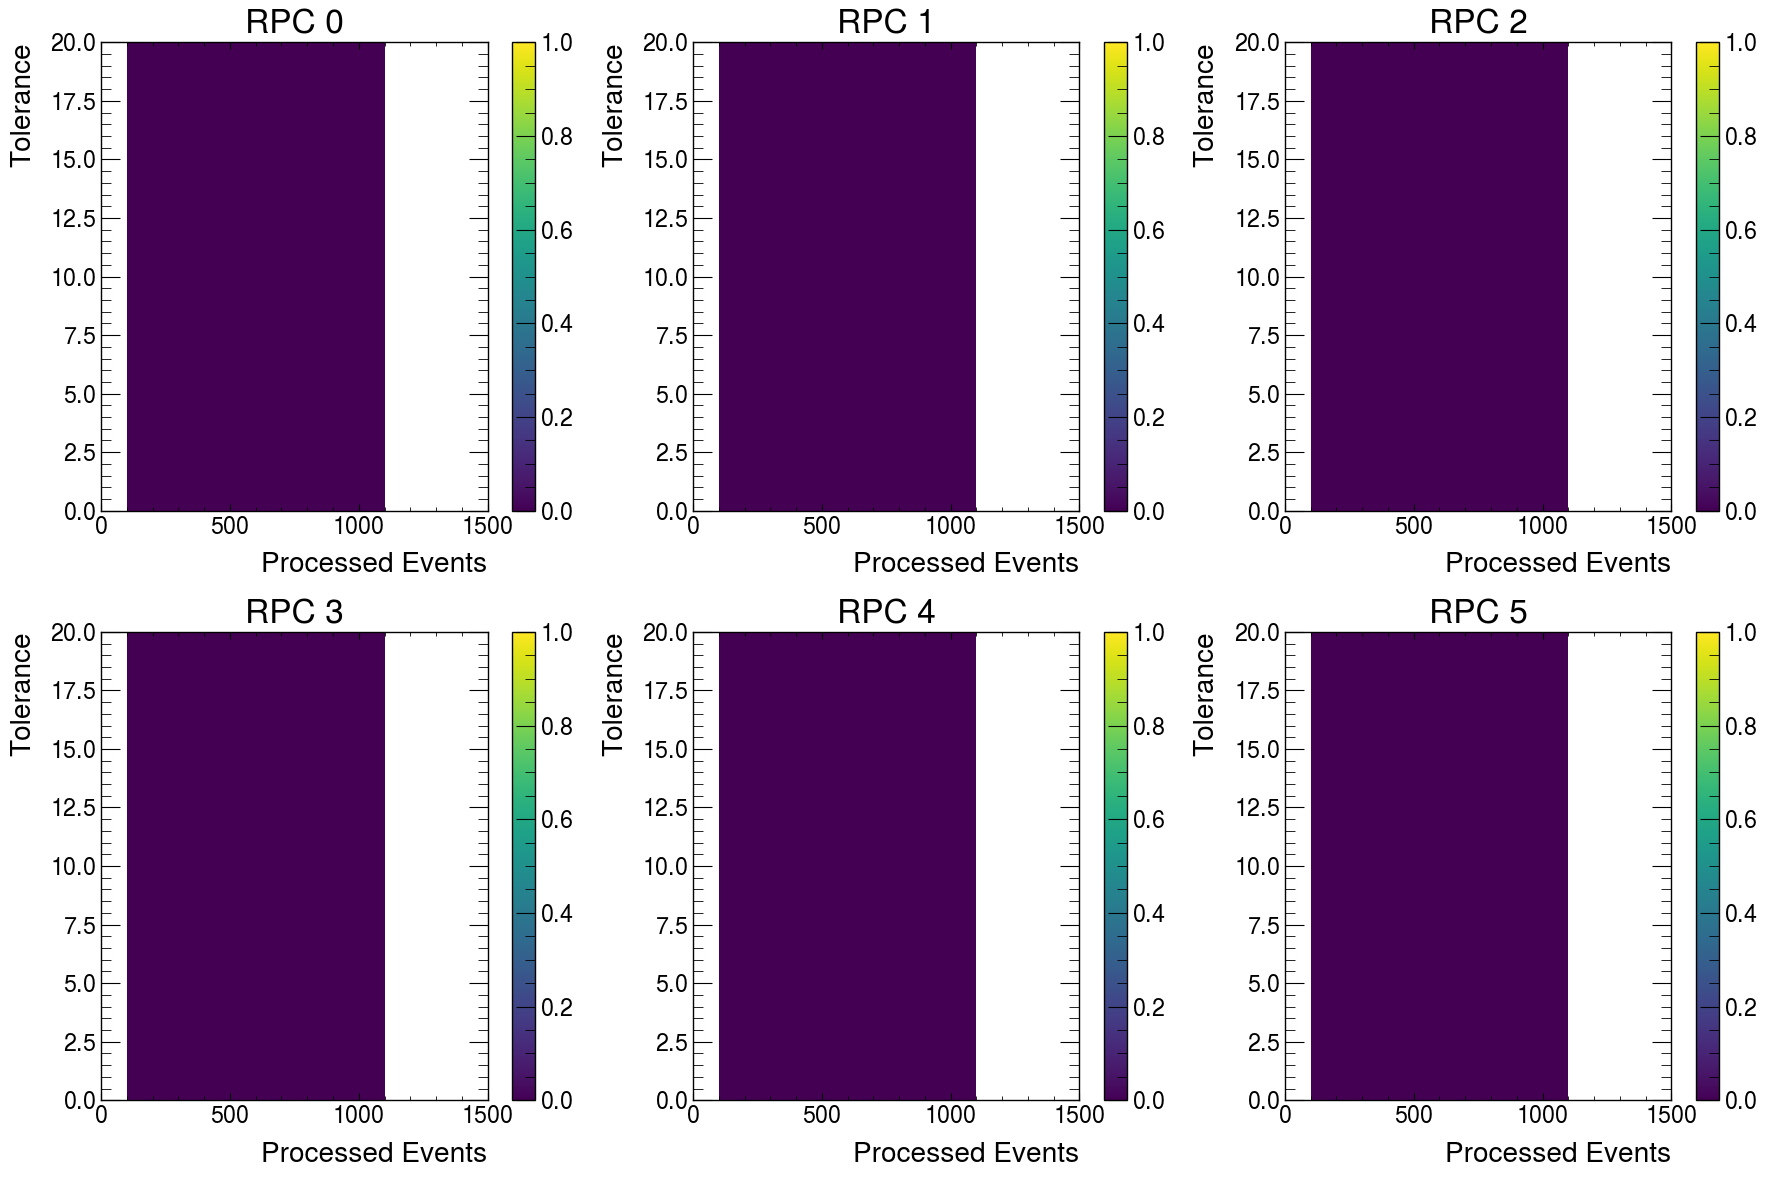

In [54]:
rAligner.plot_efficiency_heatmap()

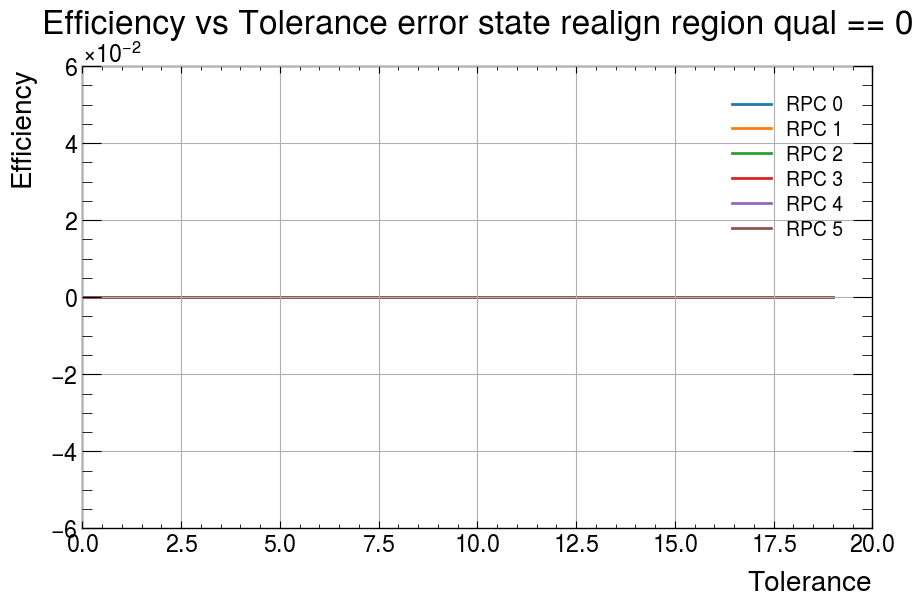

[0, 0, 0, 0, 0, 0]


In [80]:
rAligner.plot_efficiency()